In [1]:
from __future__ import division
from __future__ import print_function

import os

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

from sklearn import metrics

import scipy
from scipy import sqrt

import seaborn as sns
sns.set_style("white")

import sys
sys.path.append('../../modules/')
from Processors import *

In [2]:
from DataInfo import *

In [3]:
from helper import *

In [4]:
masses = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]
backgroundLabels = ['TT', 'WJetsToLNu']

loc = '../../../data_n/'

data = pandas.read_csv(loc + "fullData.csv", low_memory=False)
data.drop([x for x in data.columns if 'Unnamed' in x], axis=1, inplace=True)

In [5]:
removeMctMatch = True

In [6]:
indeces = {}
for mass in masses:
    indeces[str(mass)] = (data['gen_label'] == str(mass))

for background in backgroundLabels:
    indeces[background] = (data['gen_label'] == background)

In [7]:
selection = indeces[str(masses[0])]
for mass in masses[1:]:
    selection |= indeces[str(mass)]
if removeMctMatch: selection &= data['gen_mctMatch']
sigIdx = data[selection].index.tolist()
selection = indeces[backgroundLabels[0]]
for background in backgroundLabels[1:]:
    selection |= indeces[background]
bkgIdx = data[selection].index.tolist()

In [8]:
sig_devIndeces, sig_valIndeces = \
                train_test_split(sigIdx, test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = \
                train_test_split(bkgIdx, test_size=0.2, random_state=1337)

In [9]:
devIndeces = sig_devIndeces + bkg_devIndeces
valIndeces = sig_valIndeces + bkg_valIndeces

In [10]:
devData = data.iloc[sig_devIndeces].copy()
devData = devData.append(data.iloc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.iloc[sig_valIndeces].copy()
valData = valData.append(data.iloc[bkg_valIndeces].copy(), ignore_index = True)

In [11]:
genFeatures      = [x for x in data.columns if 'gen' in x]
regFeatures      = [x for x in data.columns if 'reg' in x]
regBFeatures     = [x for x in data.columns if 'regB' in x and not 'diH' in x]
regTauFeatures   = [x for x in data.columns if 'regTau' in x and not 'diH' in x]
regHH_SOFestures = [x for x in data.columns if 'regHH_SO' in x]
regHHFeatures    = [x for x in data.columns if 'regHH' in x and not 'SO' in x]
regHTTFeatures   = [x for x in data.columns if 'regHTT' in x]
regHBBFeatures   = [x for x in data.columns if 'regHBB' in x]
hlFeatures       = [x for x in data.columns if 'hl' in x]
phiFeatures      = [x for x in data.columns if 'phi' in x and not x in genFeatures+regFeatures+hlFeatures]
etaFeatures      = [x for x in data.columns if 'eta' in x and not x in genFeatures+regFeatures+hlFeatures]
cardinalFeatures = [x for x in data.columns if ('px' in x or 'py' in x or 'pz' in x) and not x in genFeatures+regFeatures+hlFeatures]
pTFeatures       = [x for x in data.columns if 'pT' in x and not x in genFeatures+regFeatures+hlFeatures]
massFeatures     = [x for x in data.columns if 'mass' in x and not x in genFeatures+regFeatures+hlFeatures]
EFeatures        = [x for x in data.columns if 'E' in x and not x in genFeatures+regFeatures+hlFeatures]
pFeatures        = [x for x in data.columns if '|p|' in x and not x in genFeatures+regFeatures+hlFeatures]
csvFeatures      = [x for x in data.columns if 'csv' in x and not x in genFeatures+regFeatures+hlFeatures]
otherGFeatures   = ['diH_kinFit_prob', 'mT', 'hT', 'sT'] #centrality, upsilon, spherocity, aplanority
otherBFeatures   = [x for x in data.columns if not x in genFeatures+regFeatures+hlFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures]
print('genFeatures:', len(genFeatures))
print('regFeatures:', len(regFeatures))
print('regBFeatures:', len(regBFeatures))
print('regTauFeatures:', len(regTauFeatures))
print('regHH_SOFestures:', len(regHH_SOFestures))
print('regHHFeatures:', len(regHHFeatures))
print('regHTTFeatures:', len(regHTTFeatures))
print('regHBBFeatures:', len(regHBBFeatures))
print('hlFeatures:', len(hlFeatures))
print('phiFeatures:', len(phiFeatures))
print('etaFeatures:', len(etaFeatures))
print('cardinalFeatures:', len(cardinalFeatures))
print('pTFeatures:', len(pTFeatures))
print('massFeatures:', len(massFeatures))
print('EFeatures:', len(EFeatures))
print('pFeatures:', len(pFeatures))
print('csvFeatures:', len(csvFeatures))
print('otherGFeatures:', len(otherGFeatures))
print('otherBFeatures:', len(otherBFeatures))

genFeatures: 51
regFeatures: 94
regBFeatures: 16
regTauFeatures: 16
regHH_SOFestures: 6
regHHFeatures: 6
regHTTFeatures: 22
regHBBFeatures: 16
hlFeatures: 69
phiFeatures: 8
etaFeatures: 7
cardinalFeatures: 23
pTFeatures: 8
massFeatures: 9
EFeatures: 7
pFeatures: 8
csvFeatures: 2
otherGFeatures: 4
otherBFeatures: 9


In [12]:
classTrainFeatures = [x for x in data.columns if x not in genFeatures]

k = regBFeatures+regTauFeatures+regHHFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures
k = [x for x in k if not x in set([x[x.find('_')+1:] for x in regFeatures])]

trainingFeatures = {'all': [x for x in data.columns if x not in genFeatures],
                    'regressed': regBFeatures+regTauFeatures+regHHFeatures+regHH_SOFestures+regHTTFeatures+regHBBFeatures,
                    'regEquivalent': list(set([x[x.find('_')+1:].replace("SO_", "") for x in regFeatures])),
                    'main': phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try1': etaFeatures+cardinalFeatures+pTFeatures+massFeatures+csvFeatures+otherGFeatures,
                    'try2': regBFeatures+regTauFeatures+regHHFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try3': k,
                    'try4': regHH_SOFestures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try5': regHTTFeatures+regHBBFeatures+regHH_SOFestures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try6': regBFeatures+regTauFeatures+regHTTFeatures+regHBBFeatures+regHH_SOFestures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'other': otherBFeatures}


#classTrainFeatures = trainingFeatures['all']
#print("Training on {} features {}". format(len(classTrainFeatures), sorted(classTrainFeatures)))

In [13]:
def analyze(kind, classes = '1', weights='class'):
    """
    kind: the ones in traingFeatures
    classes: '1' | '2'
    weights: 'class' | 'balanced'
    """
    loc = 'results_' + kind + '/' + classes + '_' + weights + '/'
    if kind not in trainingFeatures:
        raise KeyError(kind + ' is not a valid key')
    
    if not os.path.exists('results_' + kind):
        os.makedirs('results_' + kind)
    
    if not os.path.exists(loc):
        os.makedirs(loc)
        
    classTrainFeatures = trainingFeatures[kind]

    X_train = data.iloc[devIndeces][classTrainFeatures]
    X_test  = data.iloc[valIndeces][classTrainFeatures]
    
    y_train = data.iloc[devIndeces]['gen_target']
    y_test  = data.iloc[valIndeces]['gen_target']
    
    #i'm not sure about this
    if classes == '1':
        numClasses = 1
    elif classes == '2':
        numClasses = 2
        #warning here. TODO: Fix that
        devLabels = pandas.Series(np.zeros(len(devIndeces)).astype(bool))
        valLabels = pandas.Series(np.zeros(len(valIndeces)).astype(bool))
        for mass in masses[5:]:
            devLabels |= data.iloc[devIndeces]['gen_label'] == str(mass)
            valLabels |= data.iloc[valIndeces]['gen_label'] == str(mass)
        y_train[devLabels] = 2
        y_test [valLabels] = 2
    else:
        raise KeyError(classes + ' is not a valid key')
    
    weights_train = np.ones(len(y_train))
    # avoid multiple calculations of variable
    numBackground = np.sum(y_train == 0)
    if weights == 'class':
        for i in range(1, numClasses + 1):
            scale = numBackground/np.sum(y_train == i)
            weights_train[y_train == i] = scale
    elif weights == 'balanced':
        for mass in masses:
            scale = numBackground/np.sum(data.iloc[devIndeces]['gen_label'] == str(mass)) / len(masses)
            weights_train[data.iloc[devIndeces]['gen_label'] == str(mass)] = scale
    else:
        raise KeyError(weights + ' is not a valid key')
        
    # fit model on training data
    model = xgb.XGBClassifier(random_state=1337, silent=False,
                              objective='binary:logistic',
                              n_estimators=100, eval_metric='auc',
                              max_depth=4,
                              n_jobs=8) #NOTE: number of threads to execute
    model.fit(X_train, y_train, sample_weight=weights_train)

    #plot ROC
    plt.figure(figsize=[8, 8])
    plt.plot(*metrics.roc_curve(y_train.astype(bool), 1-model.predict_proba(X_train)[:,0])[:2],
             label=r'Dev, auc=${:.6f}$'.format(metrics.roc_auc_score(y_train.astype(bool), 1-model.predict_proba(X_train)[:,0])),
             color='b', linestyle='dashed')
    plt.plot(*metrics.roc_curve(y_test.astype(bool), 1-model.predict_proba(X_test)[:,0])[:2], 
             label=r'Val, auc=${:.6f}$'.format(metrics.roc_auc_score(y_test.astype(bool), 1-model.predict_proba(X_test)[:,0])),
             color='b')
    plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
    plt.xlabel('Background acceptance', fontsize=24, color='black')
    plt.ylabel('Signal acceptance', fontsize=24, color='black')
    plt.legend(loc='best', fontsize=16)
    plt.savefig(loc + 'roc.pdf')
    plt.show()
    
    #plot distribution
    params = {'hist' : True, 'kde' : False, 'norm_hist' : True, 'bins' : np.linspace(0, 1, 50)}
    plt.figure(figsize=(16, 8))
    a, b = y_test, 1-model.predict_proba(X_test)[:,0]
    signalThing, backgroundThing = b[a.astype(bool)], b[np.logical_not(a.astype(bool))]
    sns.distplot(backgroundThing, label='Background', **params)
    sns.distplot(signalThing, label='Signal', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel("Class prediction", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
    plt.xlim([0,1])
    plt.yscale('log', nonposy='clip')
    plt.savefig(loc + 'distribution.pdf')
    plt.show()
    
    with open(loc + 'results.txt', 'w') as file:
        print(metrics.roc_auc_score(y_train.astype(bool), 1-model.predict_proba(X_train)[:,0]), file=file)
        print(metrics.roc_auc_score(y_test.astype(bool), 1-model.predict_proba(X_test)[:,0]), file=file)
    
    #FOM
    backgroundScore, signalScore = [], []

    for label in backgroundLabels:
        selection = data.iloc[valIndeces]['gen_label'] == label
        backgroundScore.append(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0])

    for mass in masses:
        selection = data.iloc[valIndeces]['gen_label'] == str(mass)
        signalScore.append(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0])
        #print(mass, np.average(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0]))
    
    def FOMAfterCutWorse(p):
        cutSignal, cutBackground = [], []
        for i, scores in enumerate(signalScore):
            #NOTE: since this is using only the test data this must be divided by test_size
            if removeMctMatch:
                normalize = np.sum(data[indeces[str(masses[i])]]['gen_mctMatch'])
            else:
                normalize = signalSkimSize[i]
            cutSignal.append(np.sum(scores > p) / len(scores) * normalize)
        for i, scores in enumerate(backgroundScore):
            cutBackground.append(np.sum(scores > p) / len(scores) * backgroundSkimSize[i])

        return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), min)
    
    x = np.linspace(0,1,501)
    y = []
    for i in x:
        y.append(FOMAfterCutWorse(i))
        if y[-1] == -1:
            y = y[:-1]
            break
    x = x[:len(y)]
    
    plt.xlabel('cut')
    plt.ylabel('FOM')
    plt.title('Worse')
    plt.xlim(0,1)
    plt.plot(x, y)
    plt.savefig(loc + 'FOM_worse.pdf')
    plt.show()
    
    # save results
    results = pandas.DataFrame({'gen_target': data['gen_target'],
                                'predict_proba_'+kind+'_'+classes+'_'+weights: 1-model.predict_proba(data[classTrainFeatures])[:,0]})
    results.to_csv(loc+'data_'+kind+'_'+classes+'_'+weights+'.csv', index=False)
    
    del model

try3 1 class :


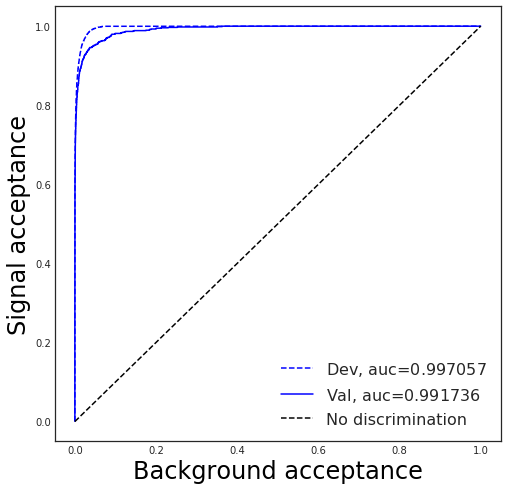

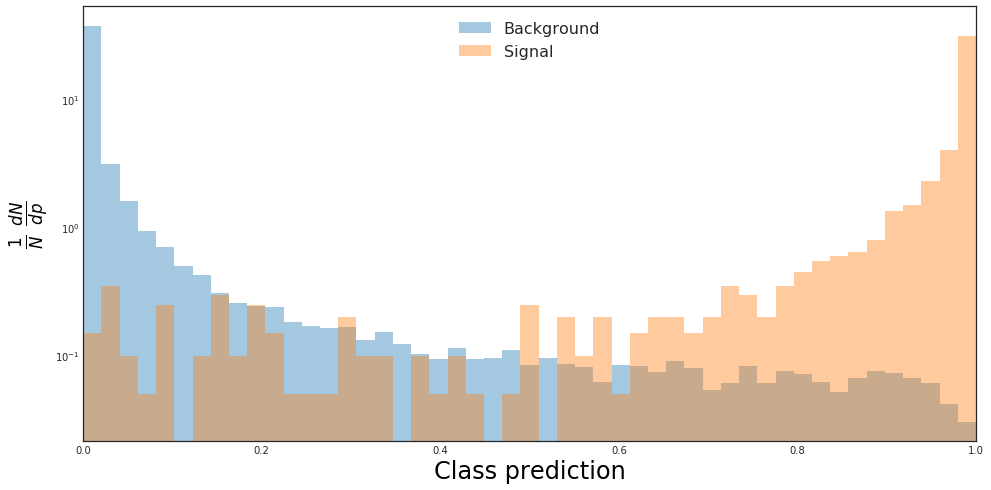

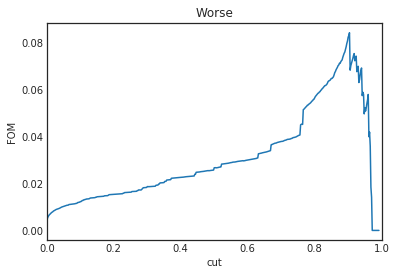

try3 1 balanced :


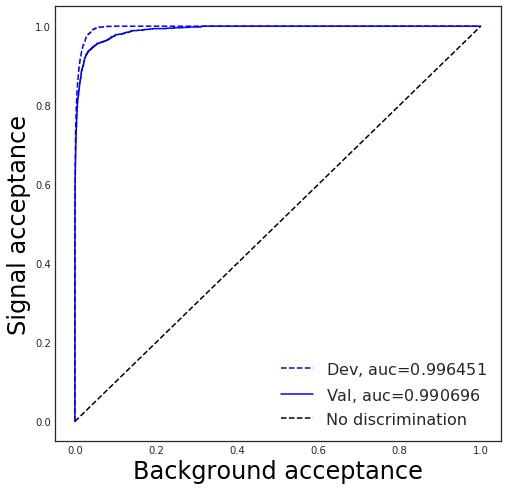

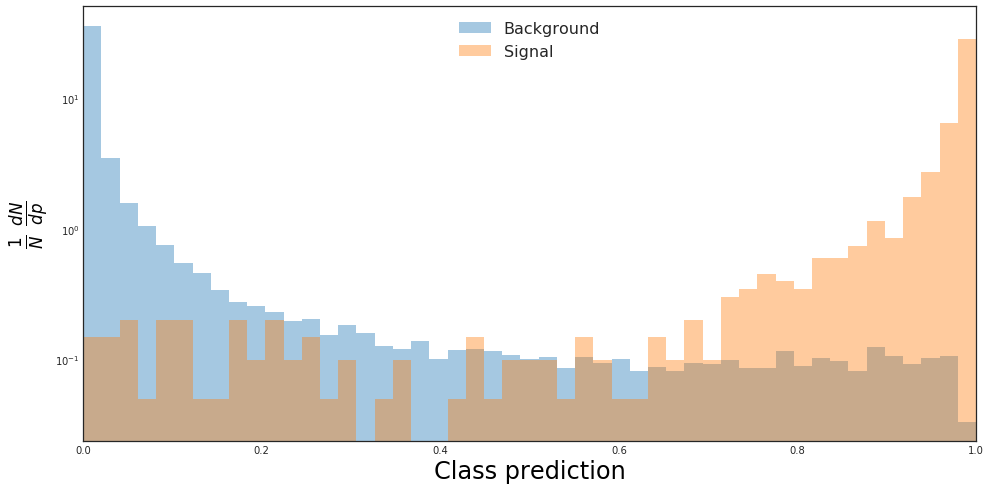

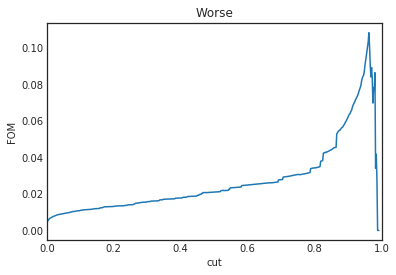

try3 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


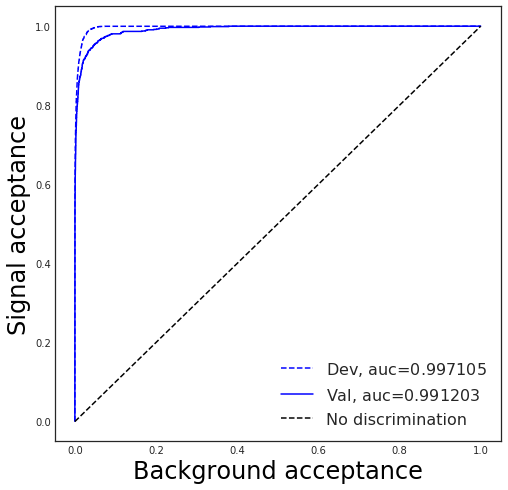

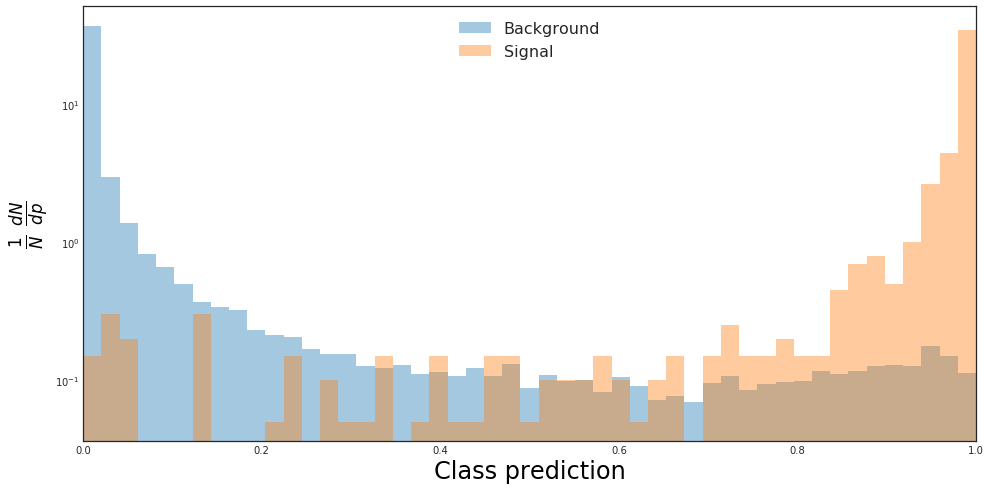

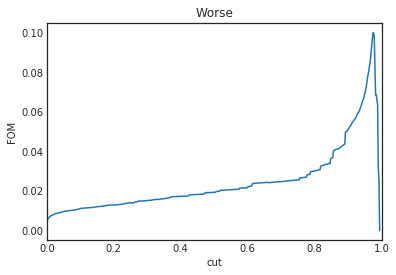

try3 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


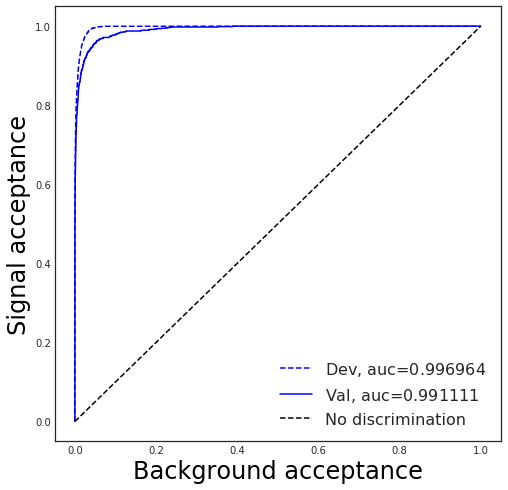

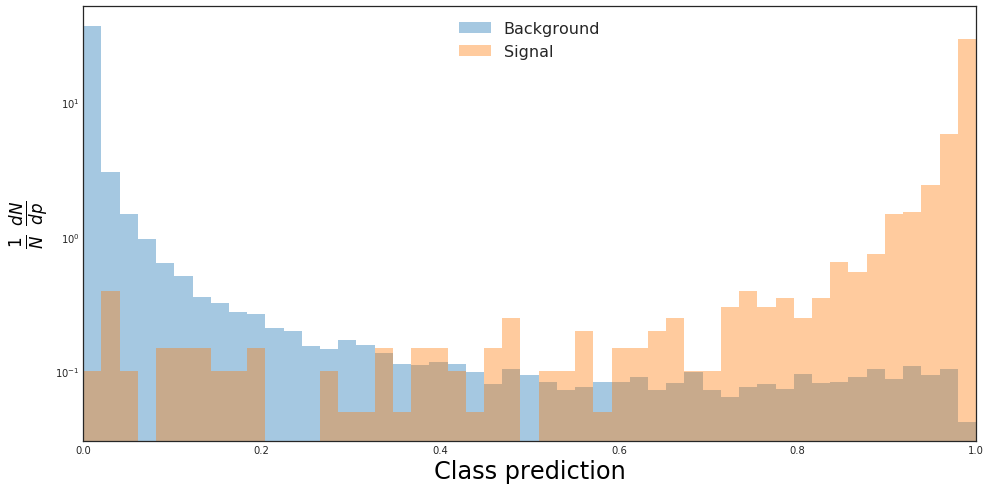

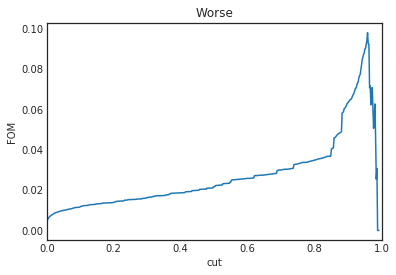

try4 1 class :


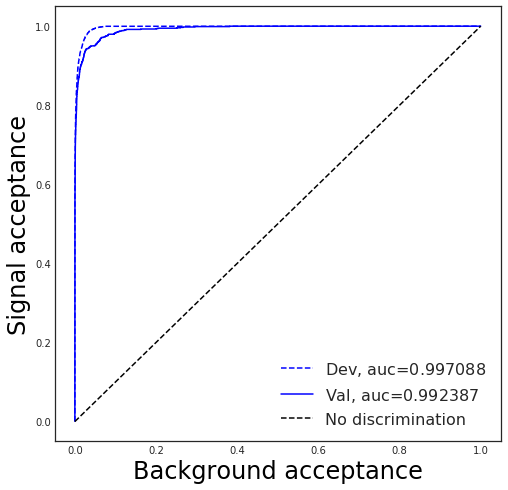

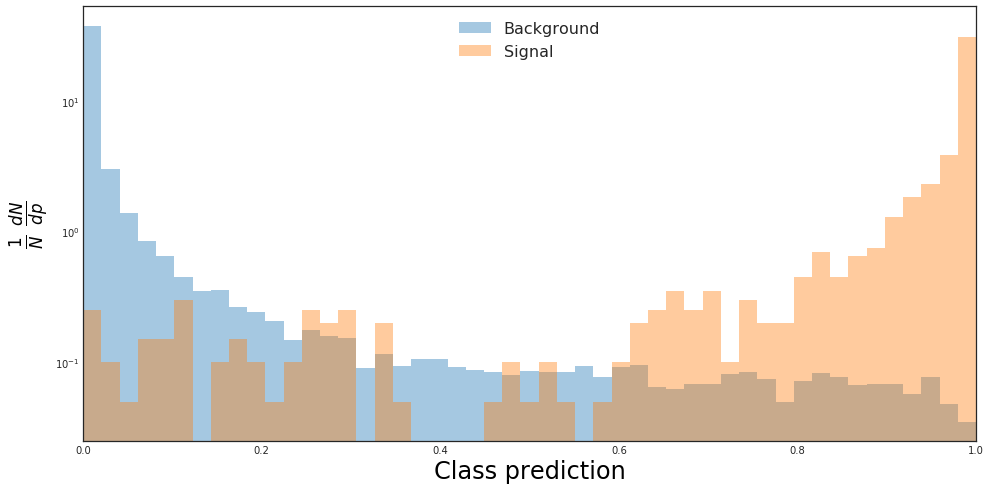

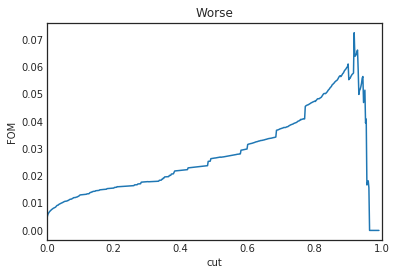

try4 1 balanced :


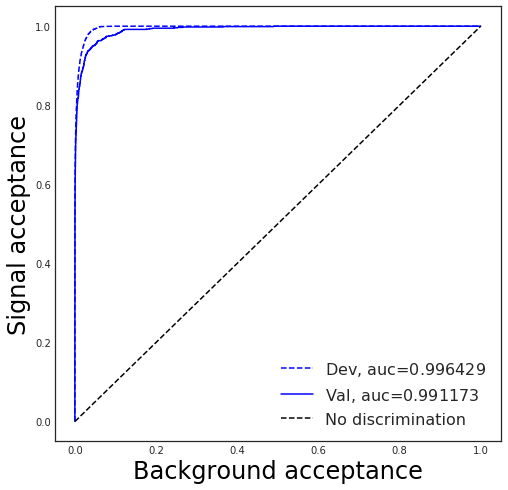

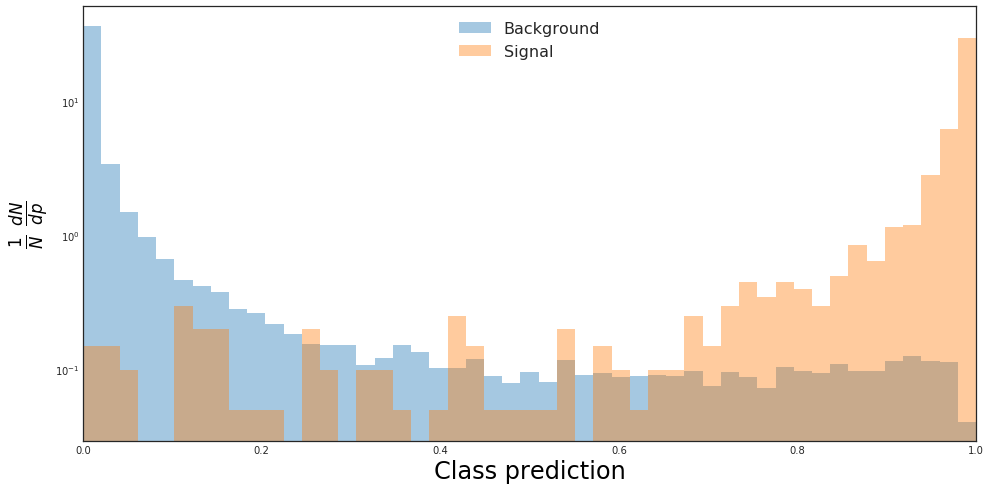

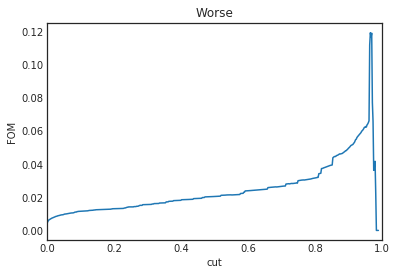

try4 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


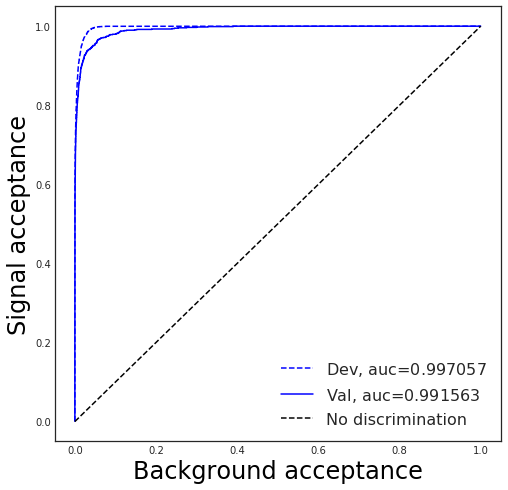

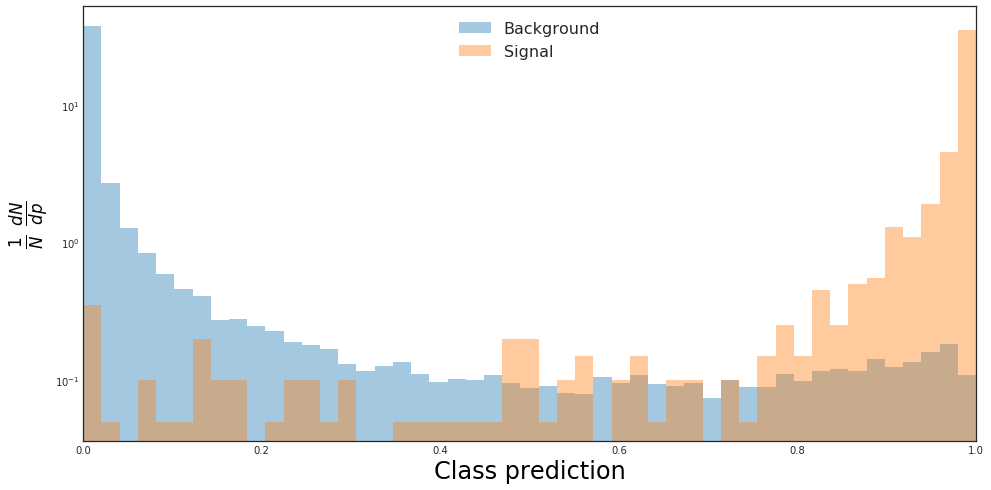

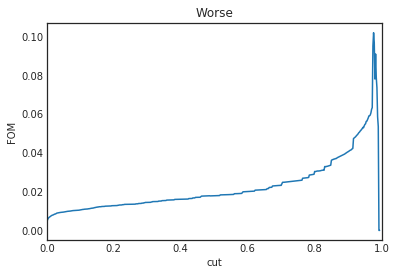

try4 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


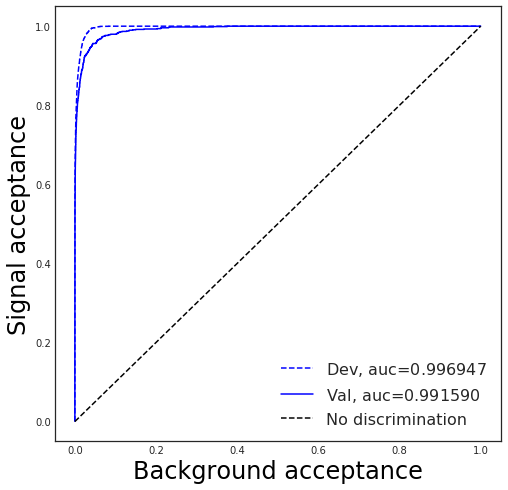

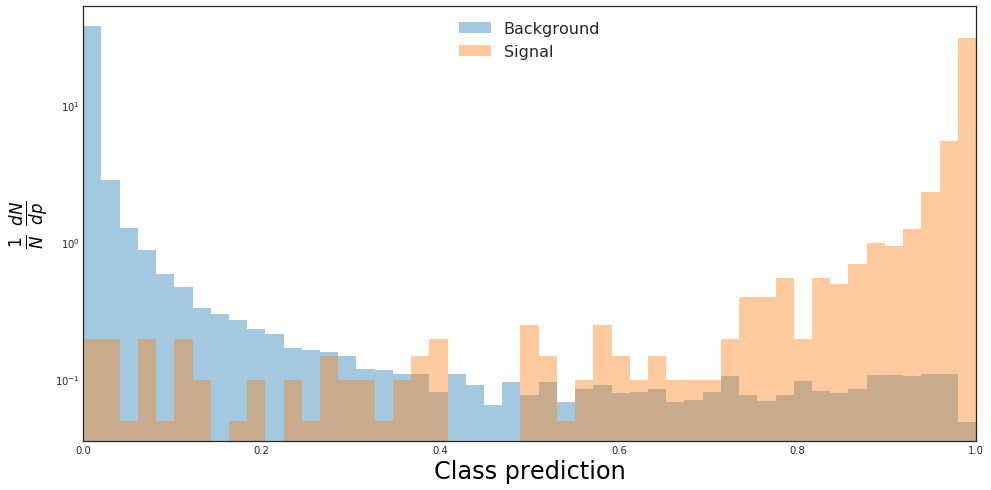

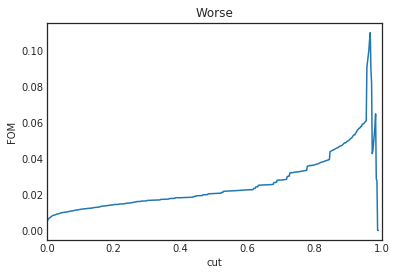

try1 1 class :


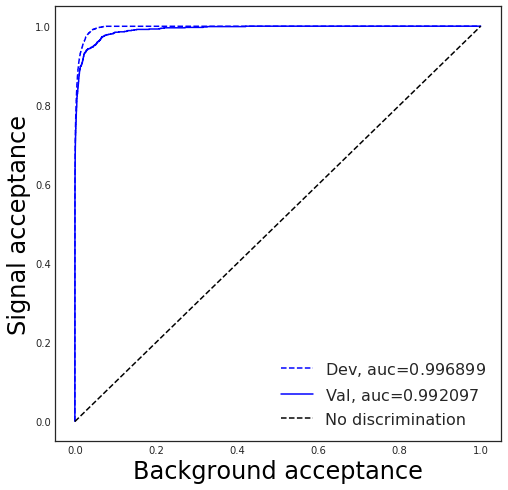

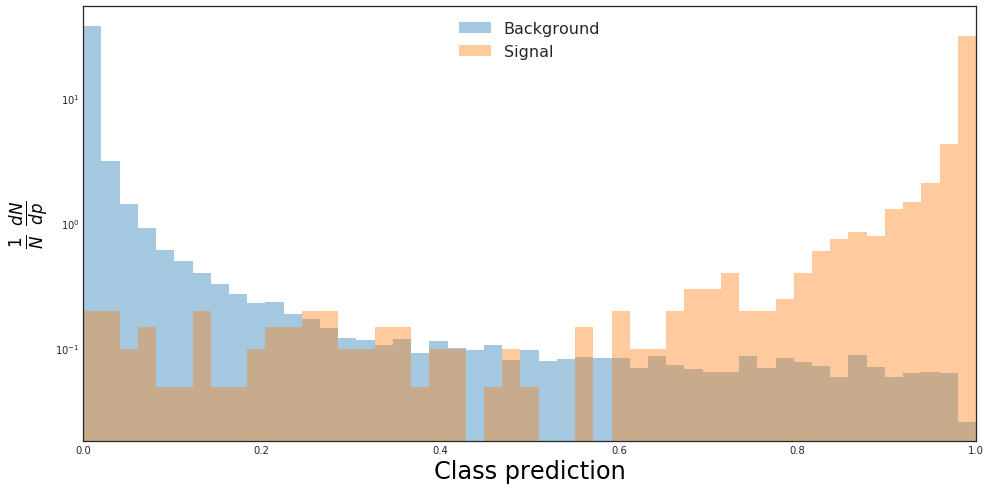

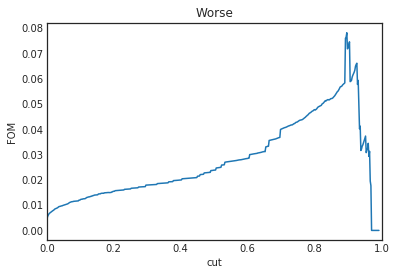

try1 1 balanced :


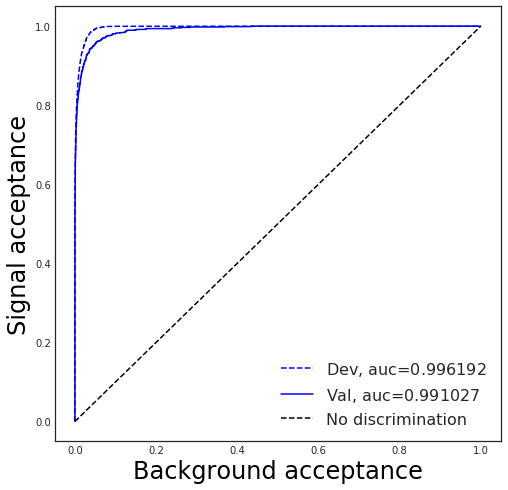

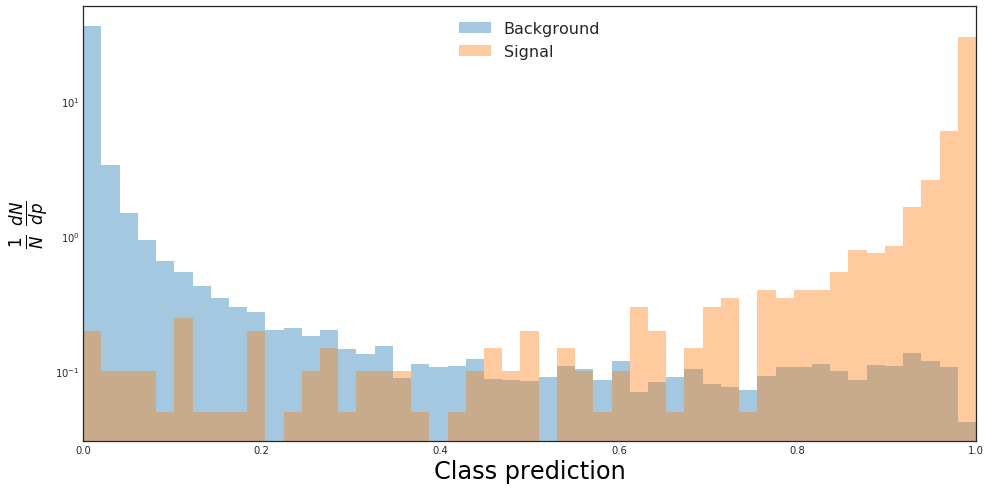

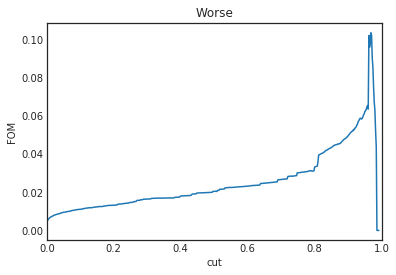

try1 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


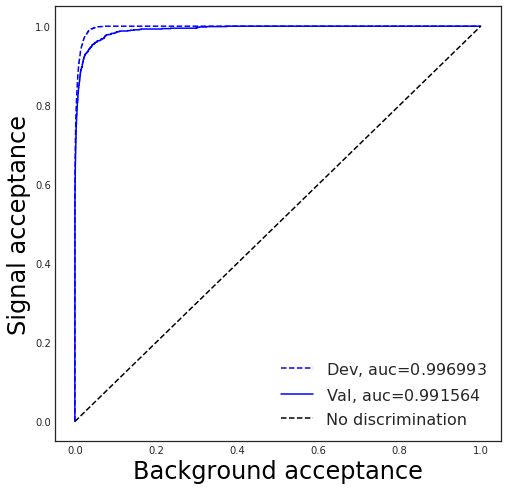

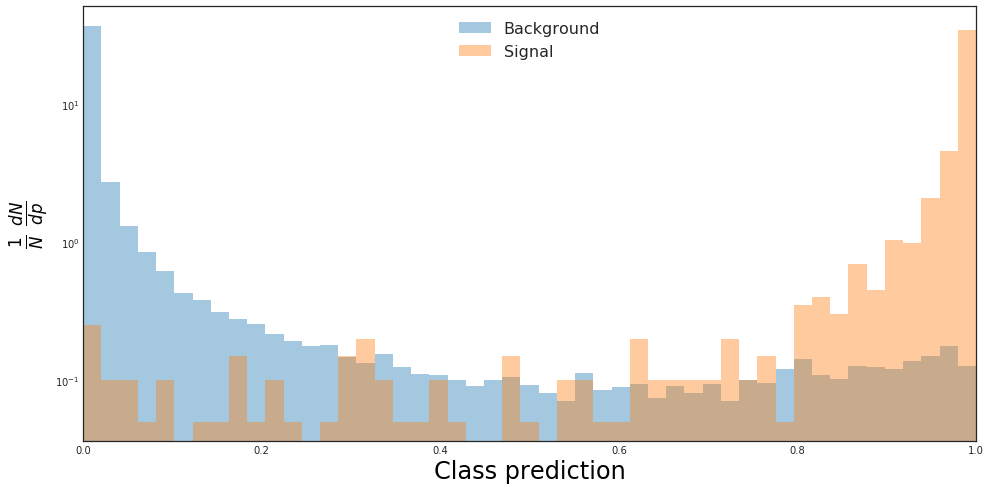

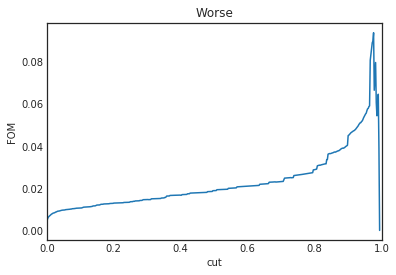

try1 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


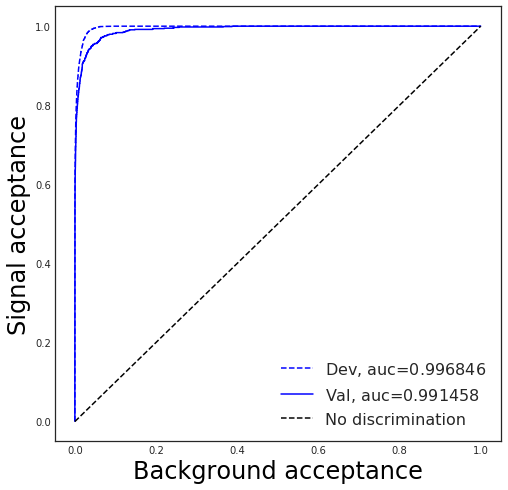

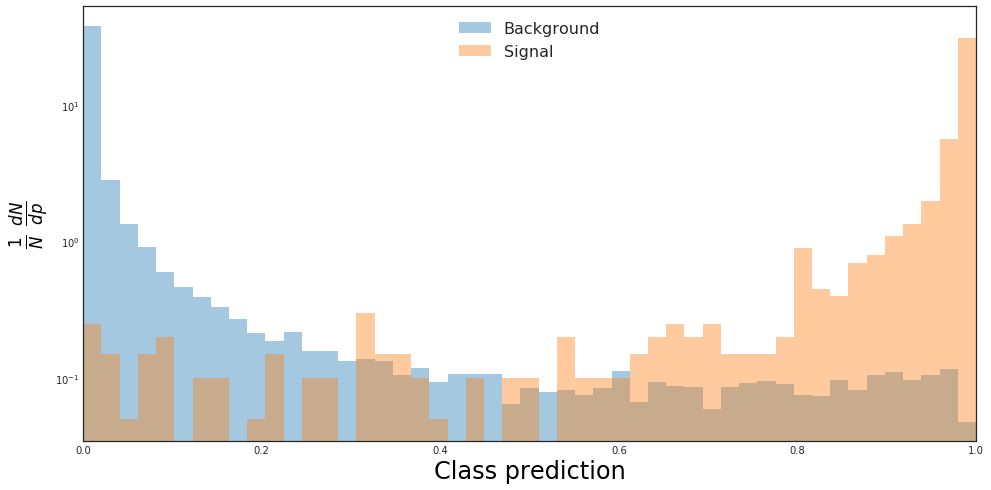

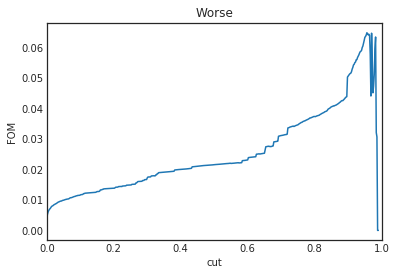

main 1 class :


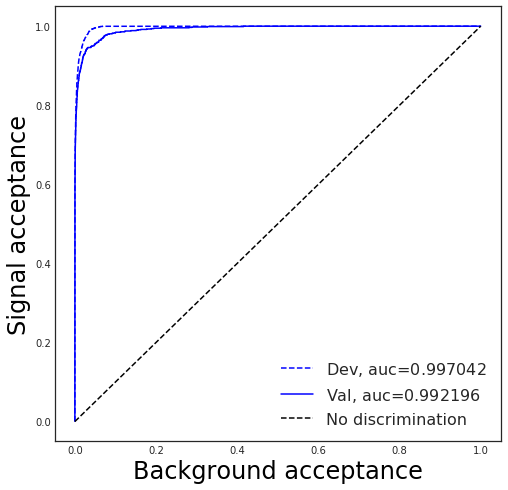

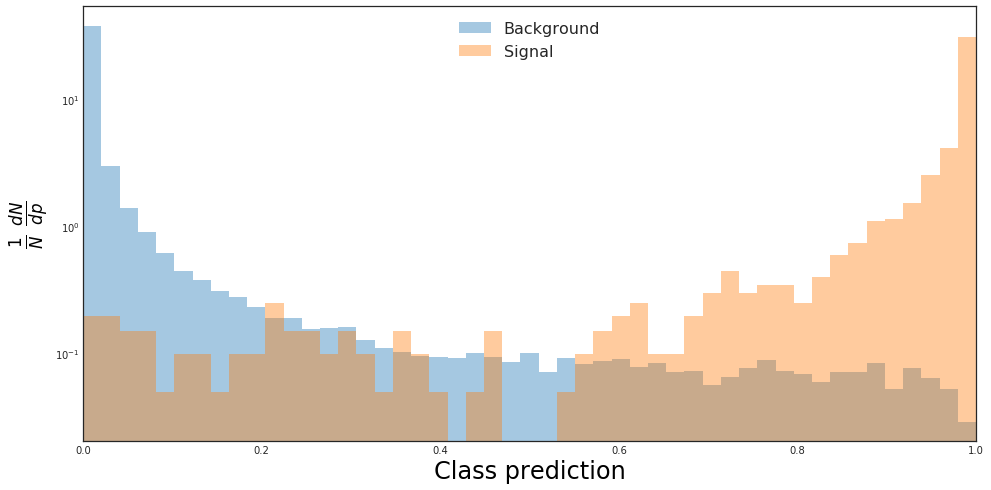

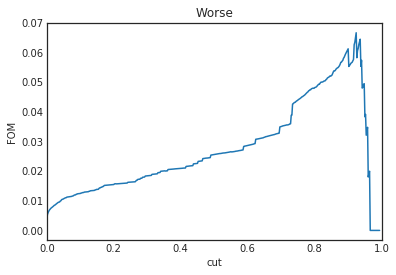

main 1 balanced :


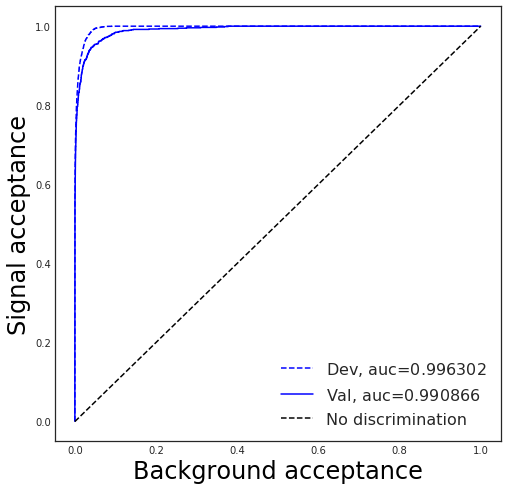

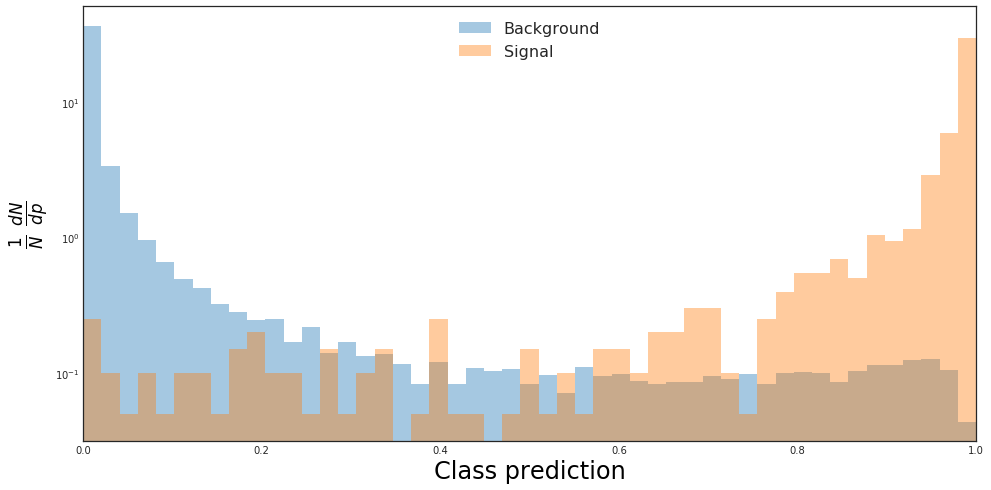

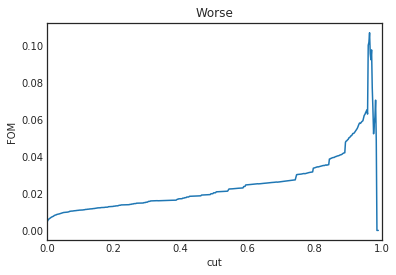

main 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


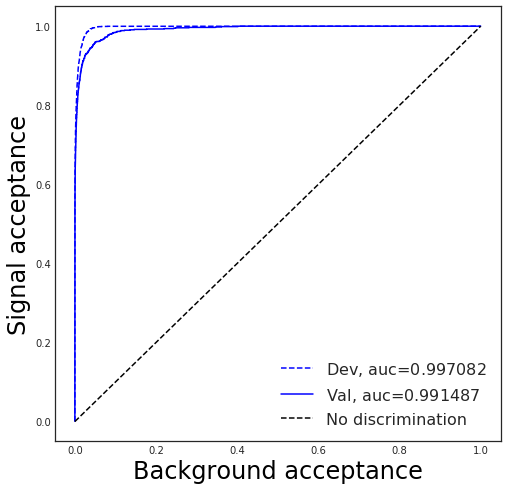

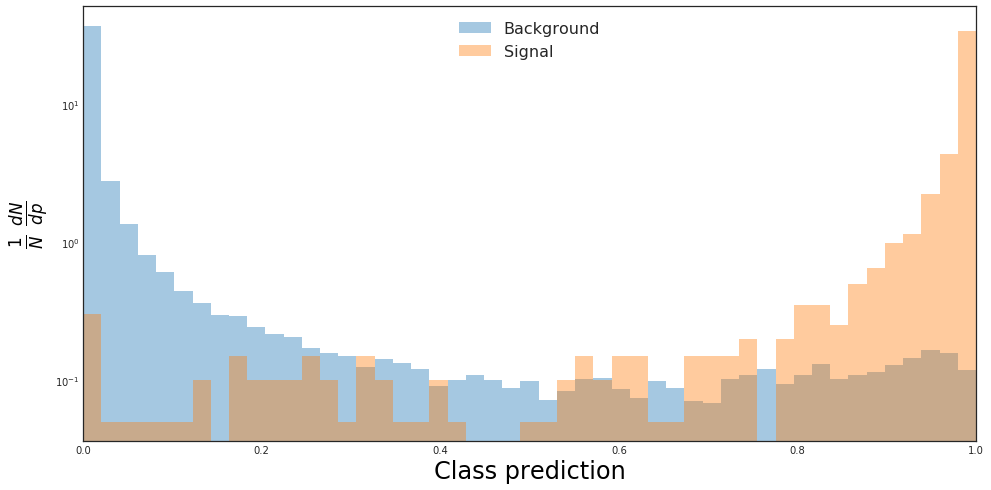

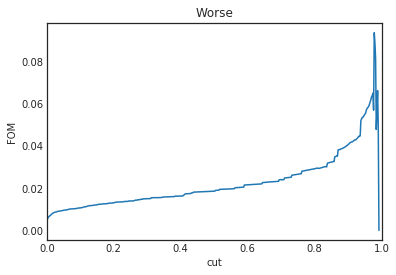

main 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


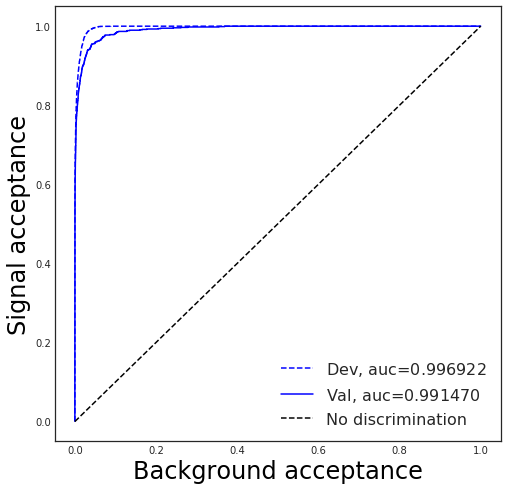

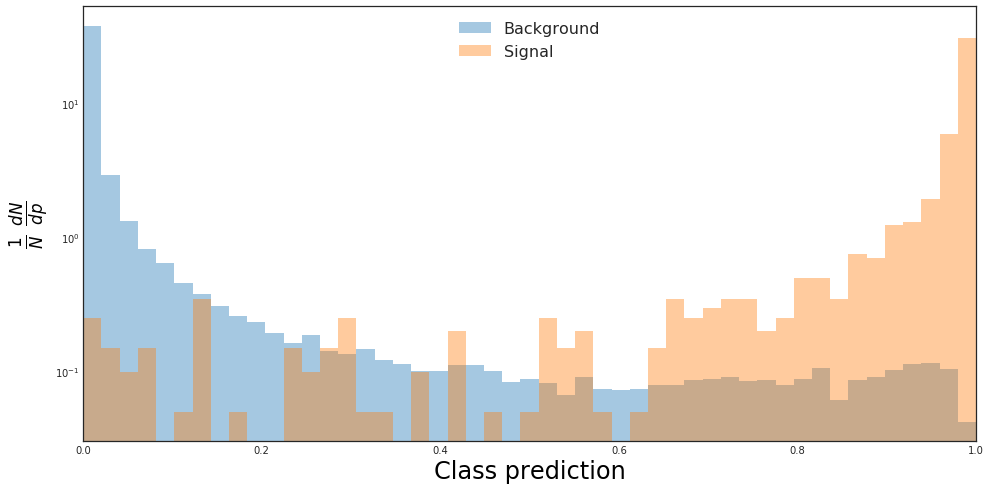

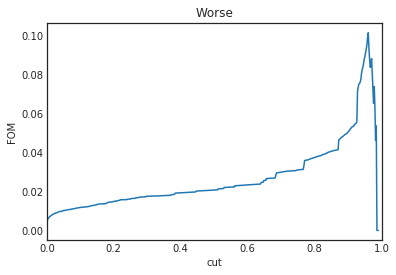

try6 1 class :


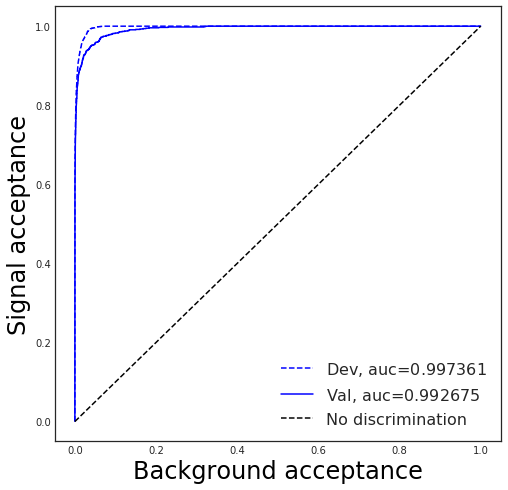

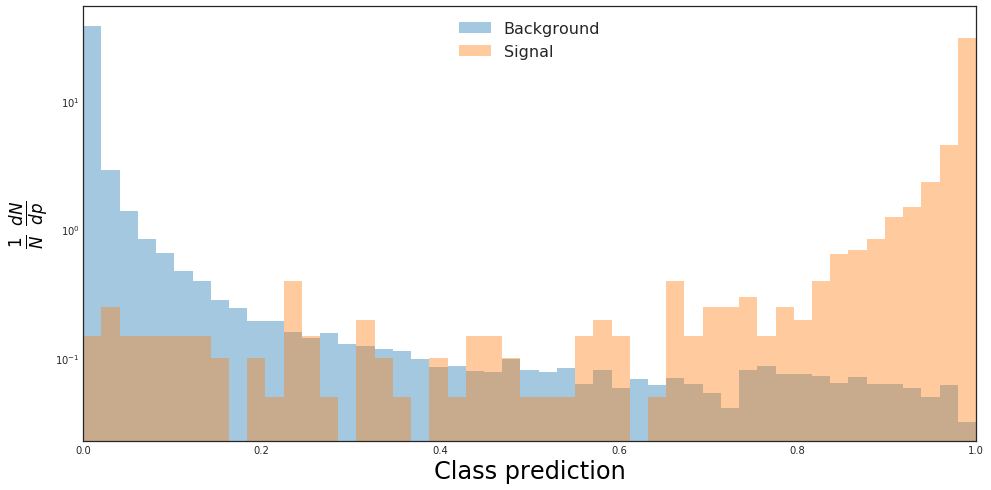

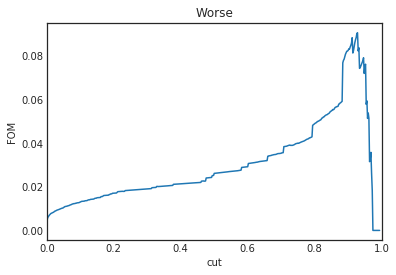

try6 1 balanced :


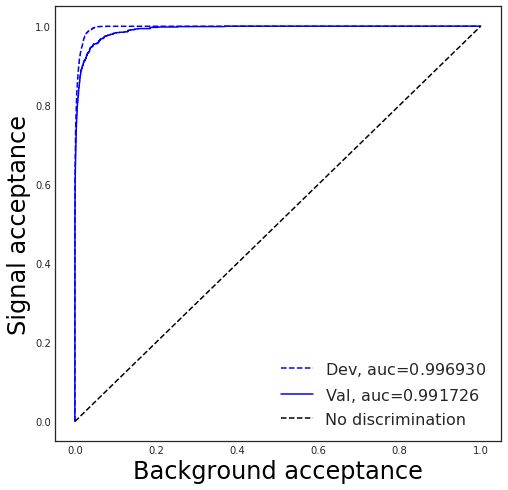

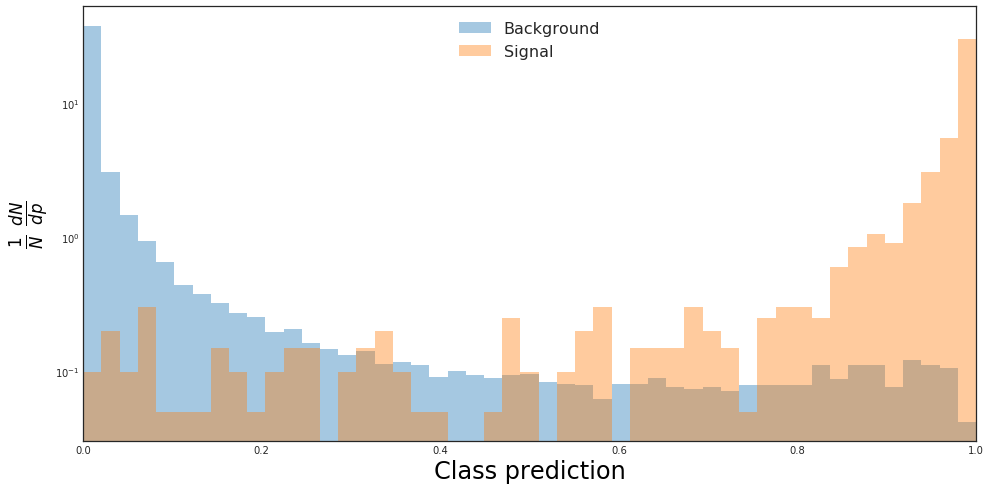

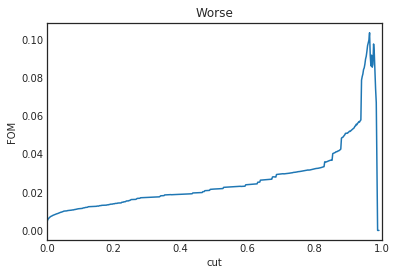

try6 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


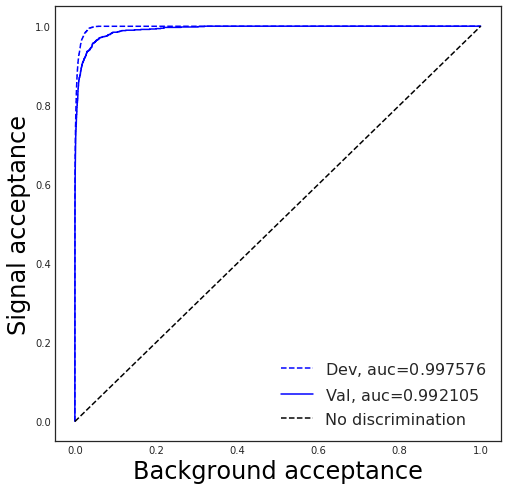

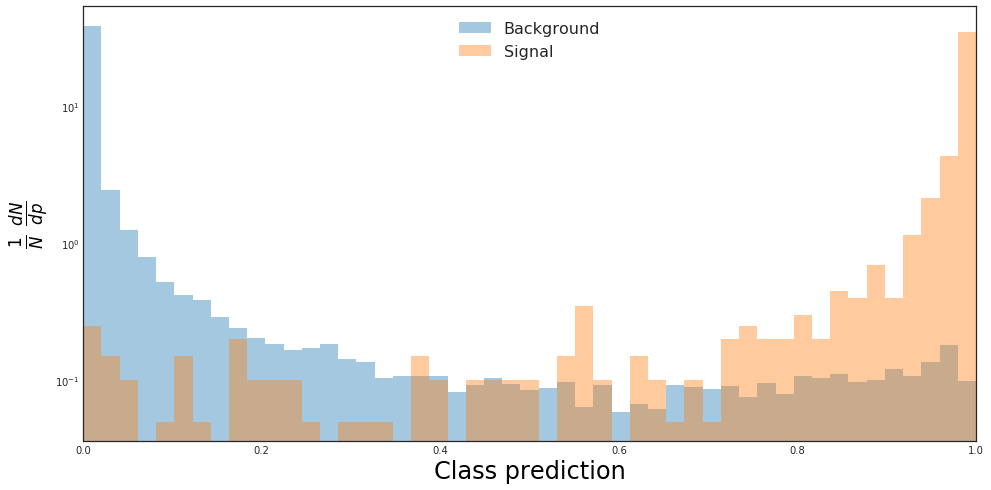

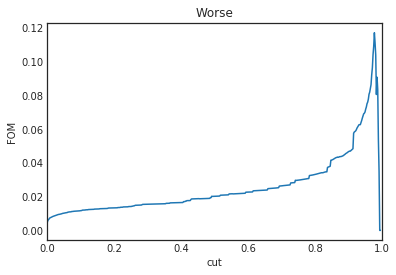

try6 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


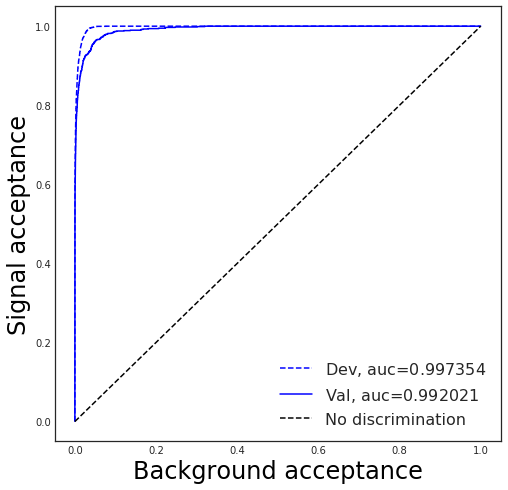

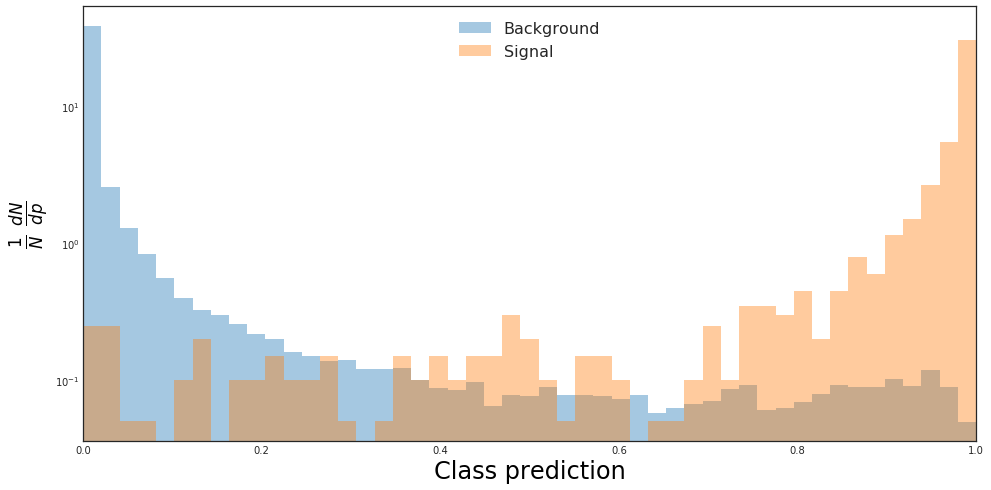

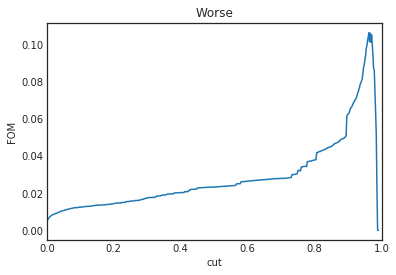

regressed 1 class :


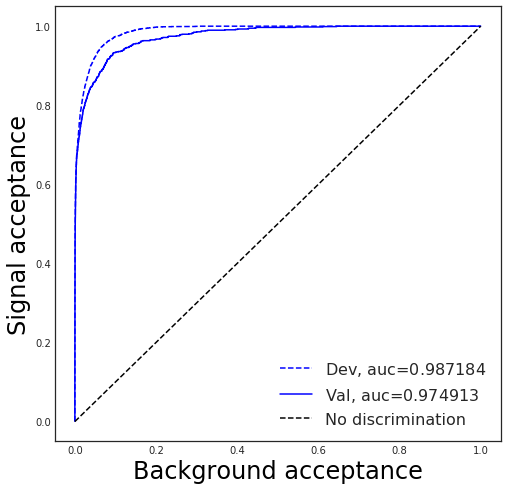

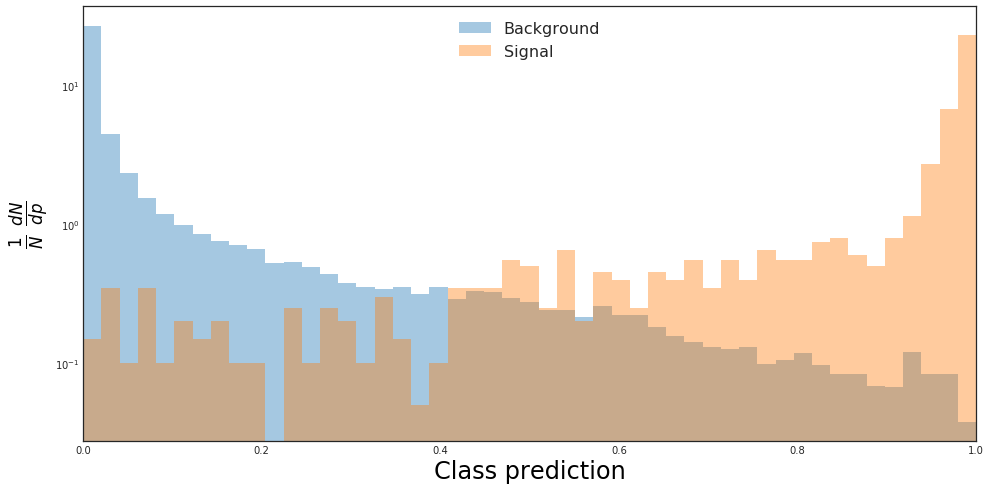

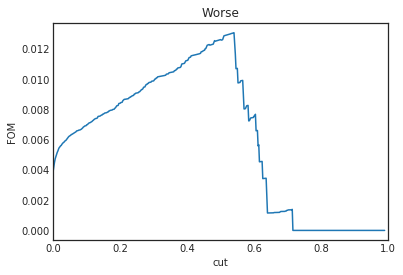

regressed 1 balanced :


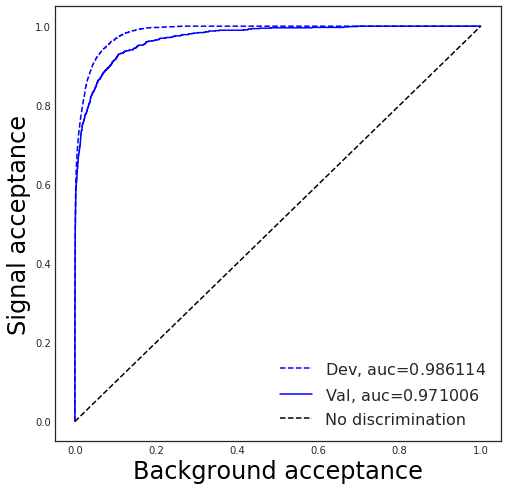

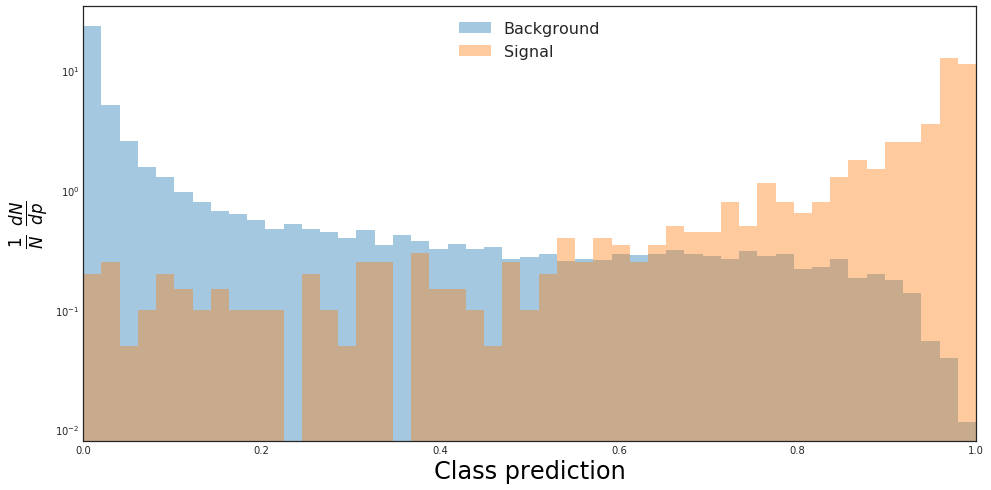

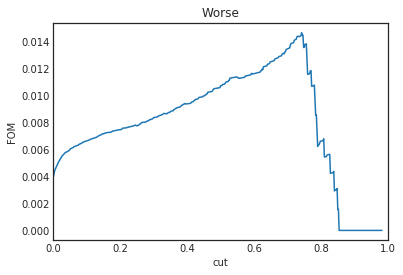

regressed 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


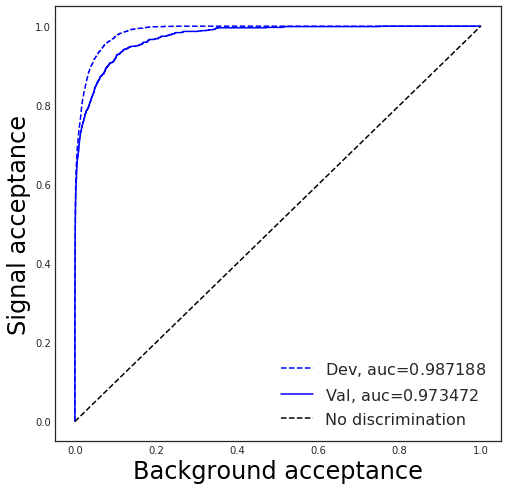

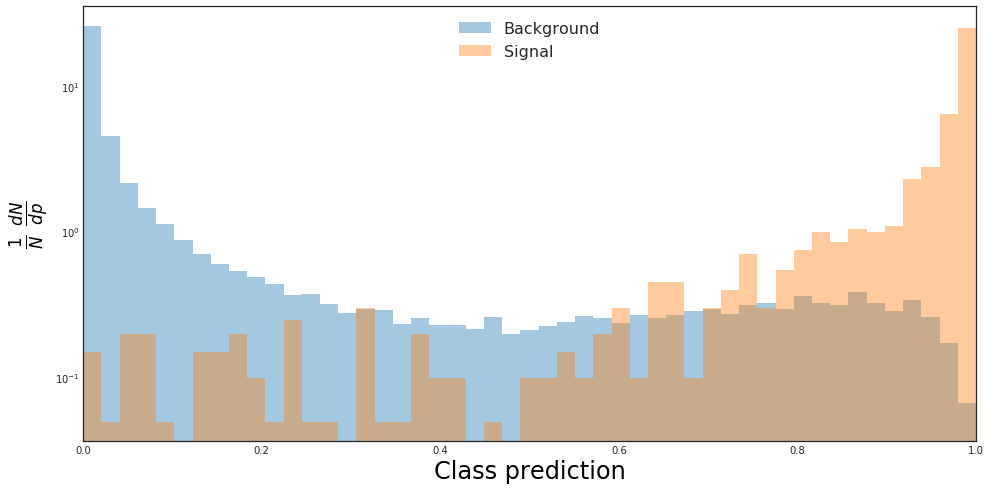

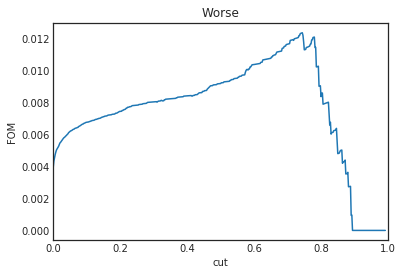

regressed 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


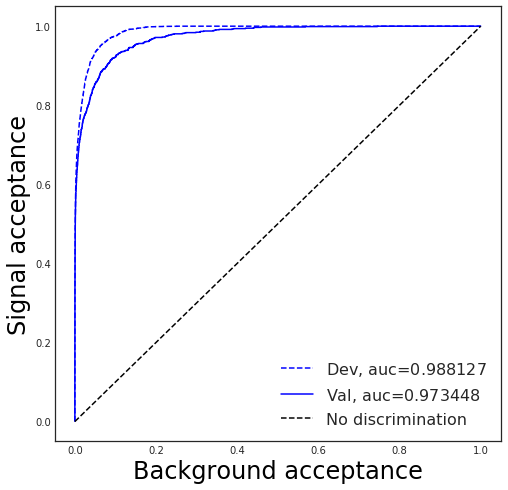

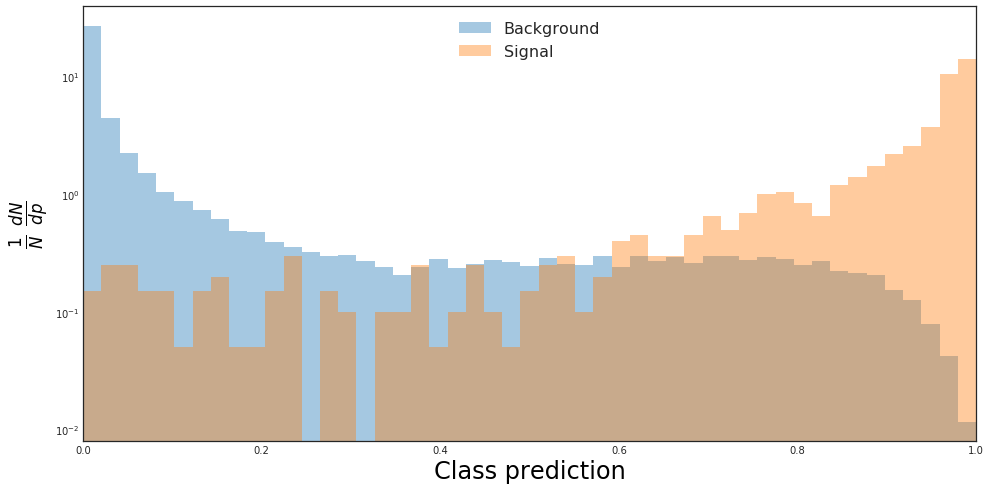

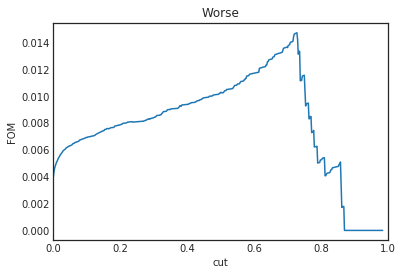

try5 1 class :


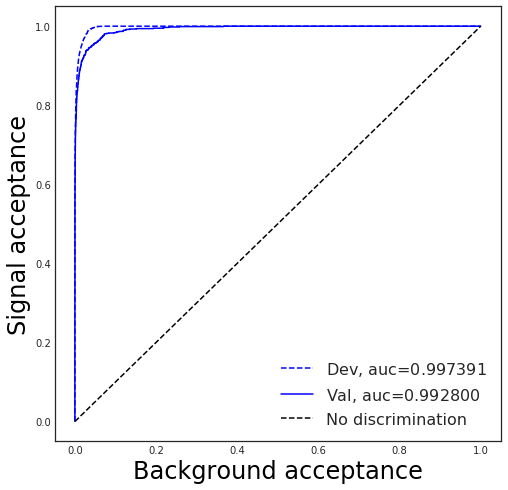

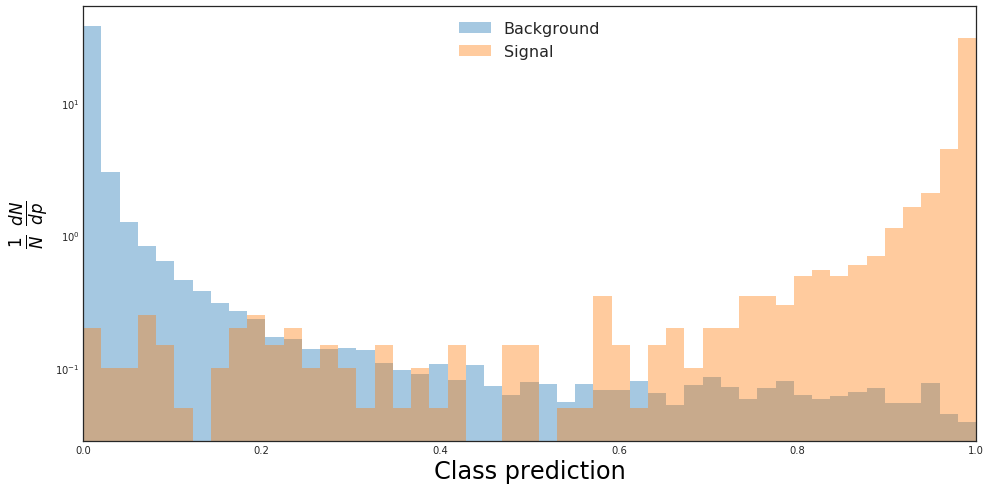

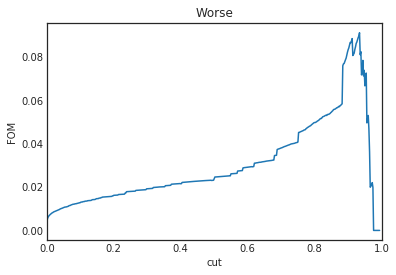

try5 1 balanced :


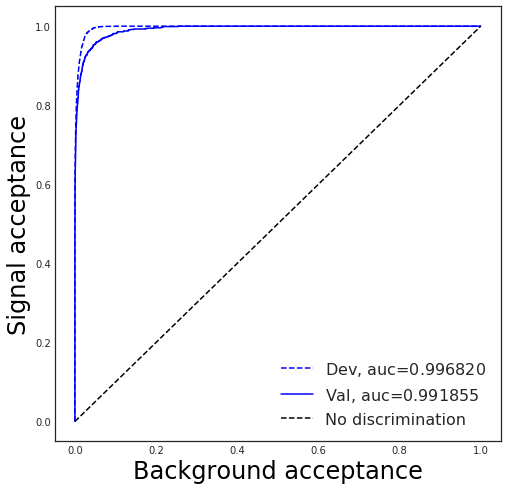

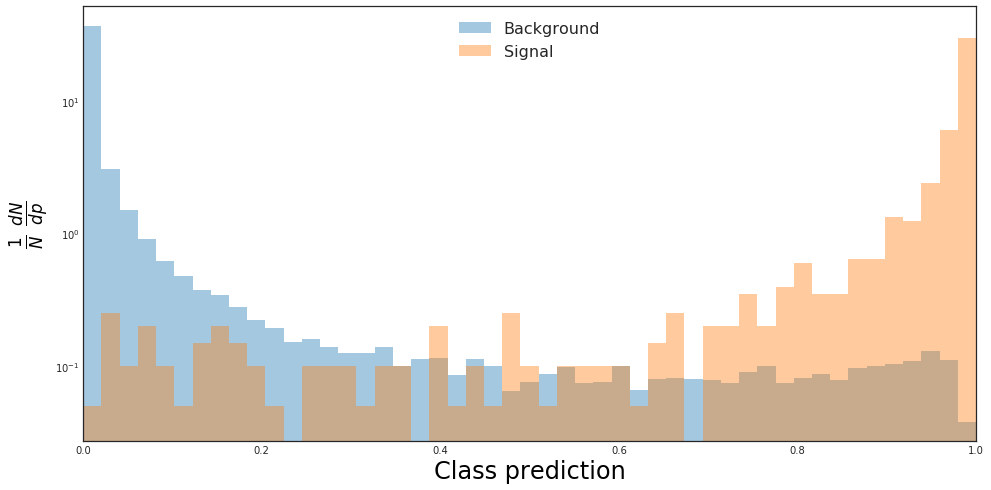

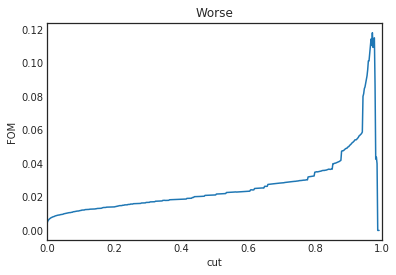

try5 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


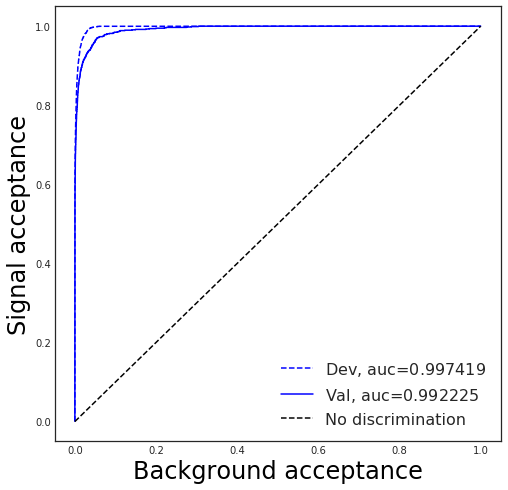

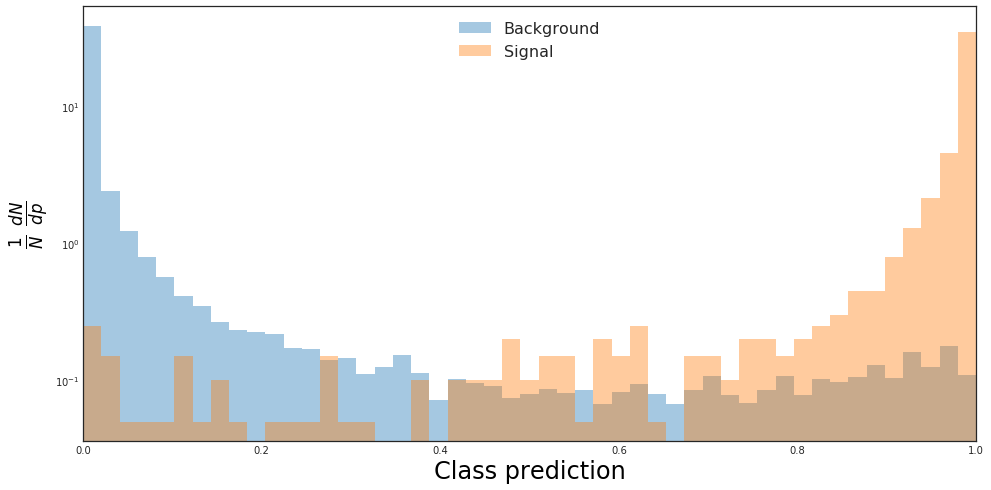

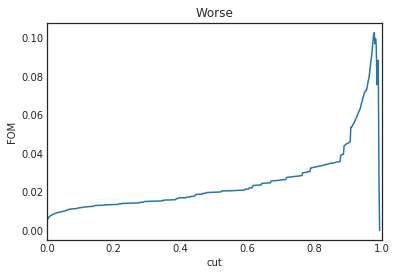

try5 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


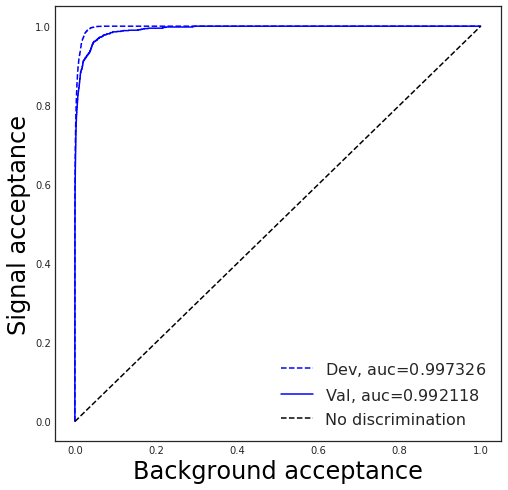

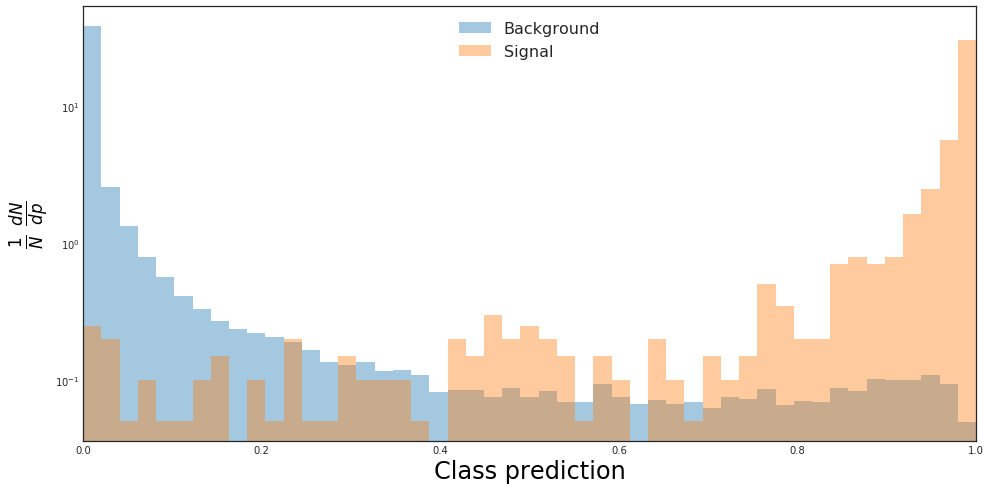

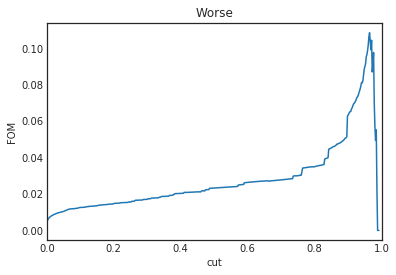

regEquivalent 1 class :


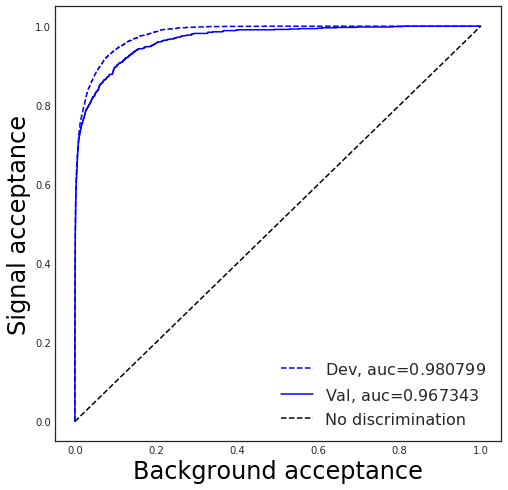

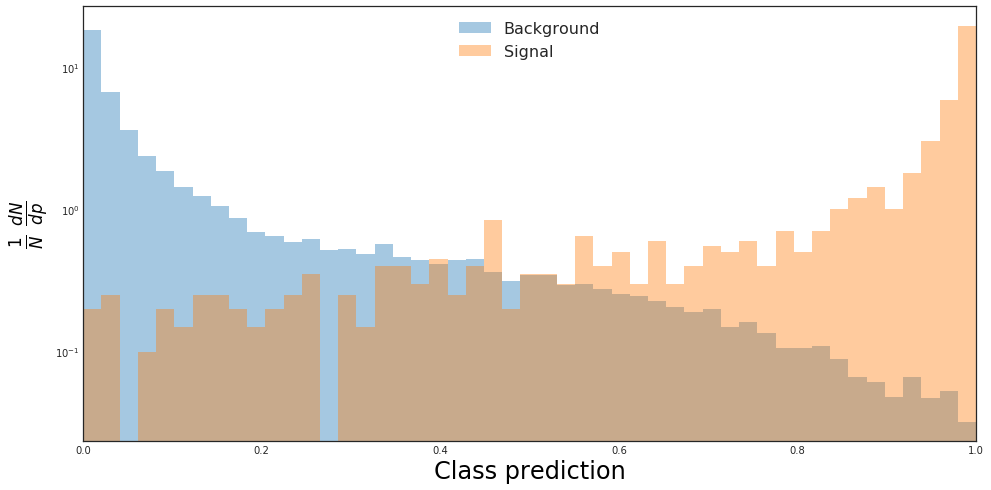

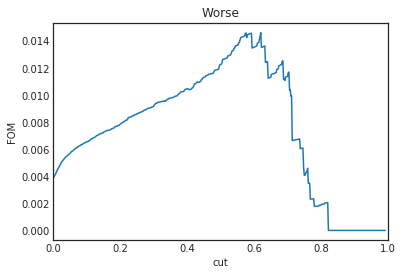

regEquivalent 1 balanced :


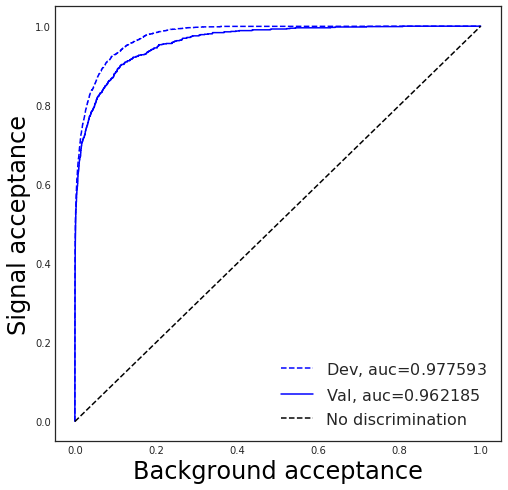

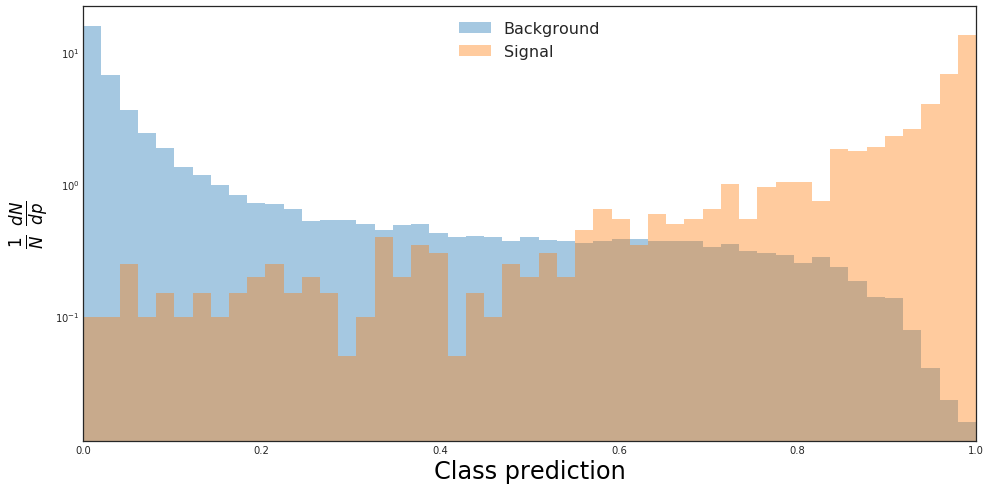

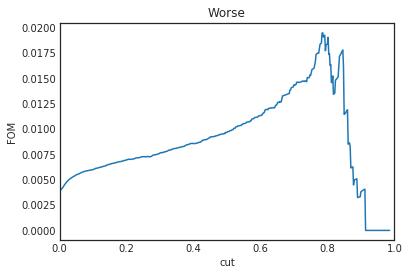

regEquivalent 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


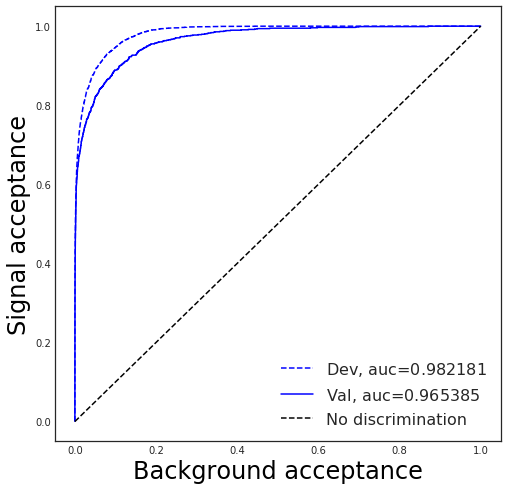

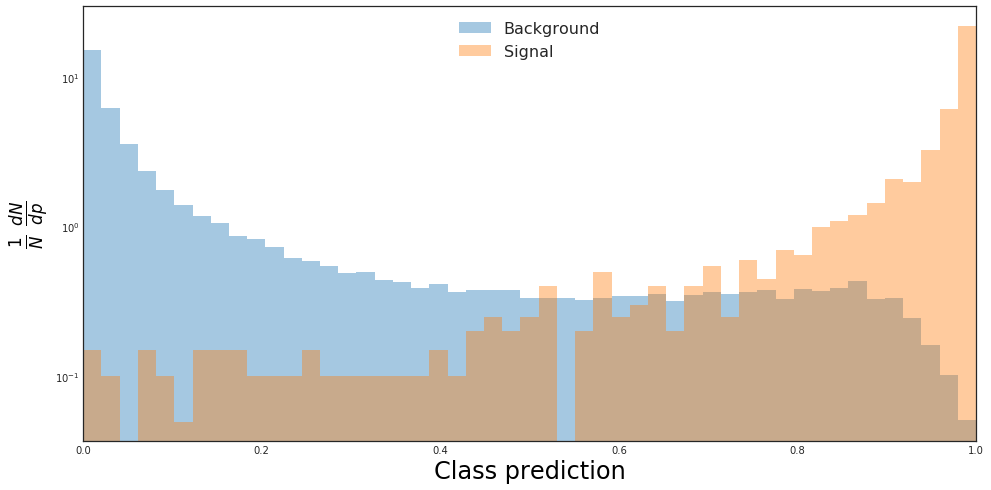

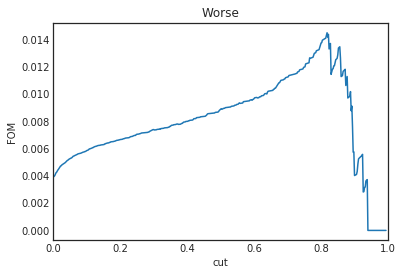

regEquivalent 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


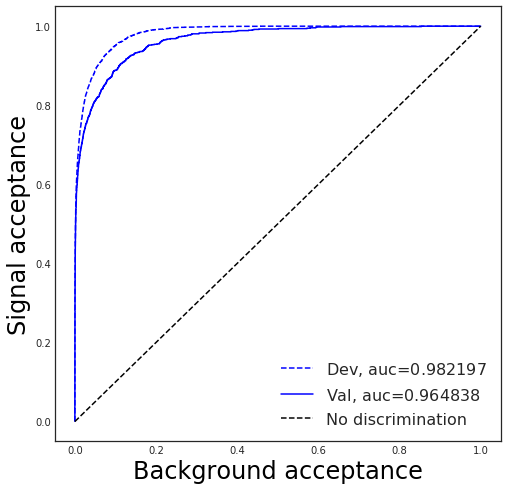

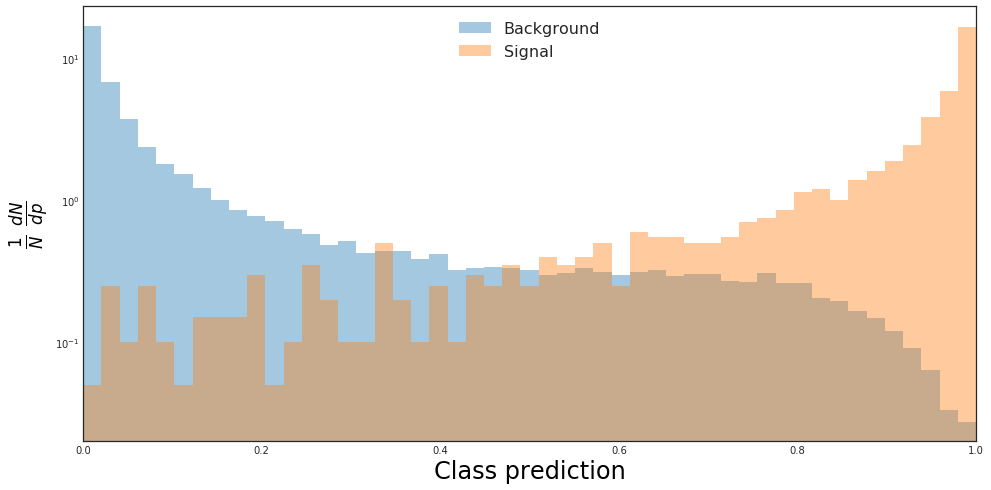

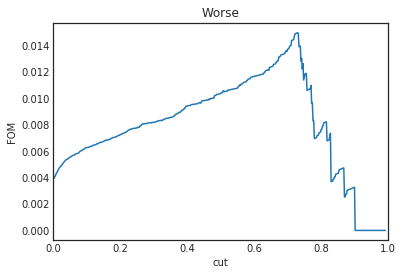

other 1 class :


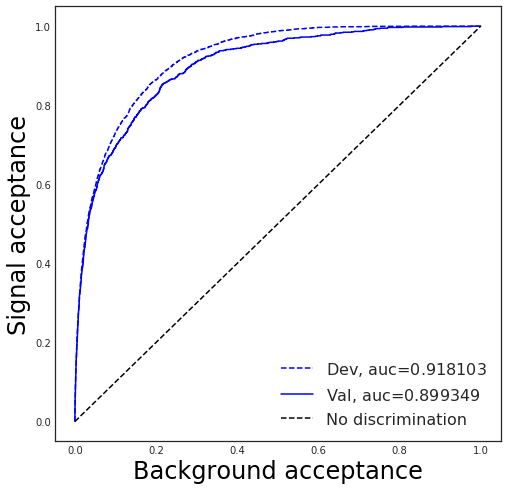

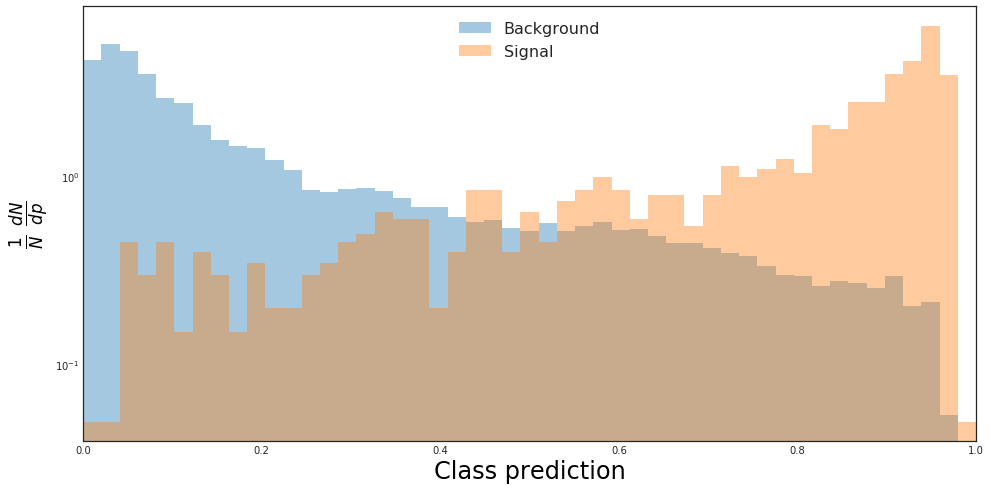

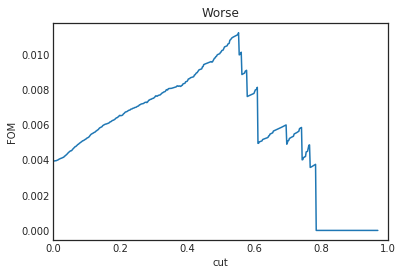

other 1 balanced :


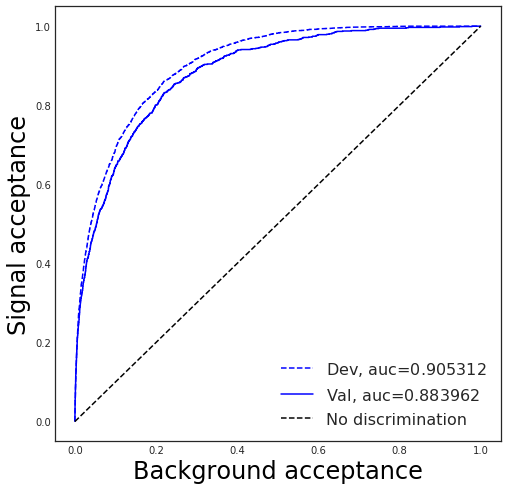

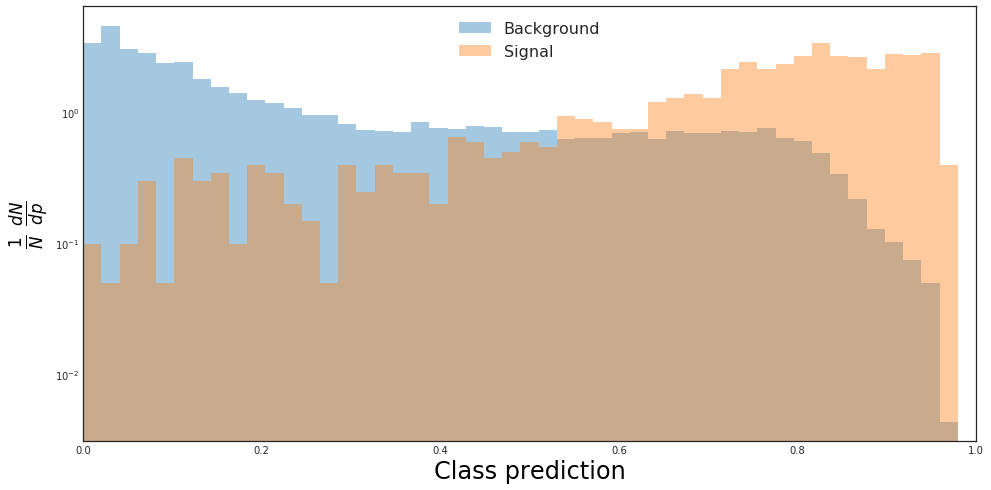

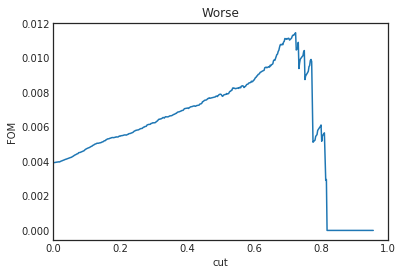

other 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


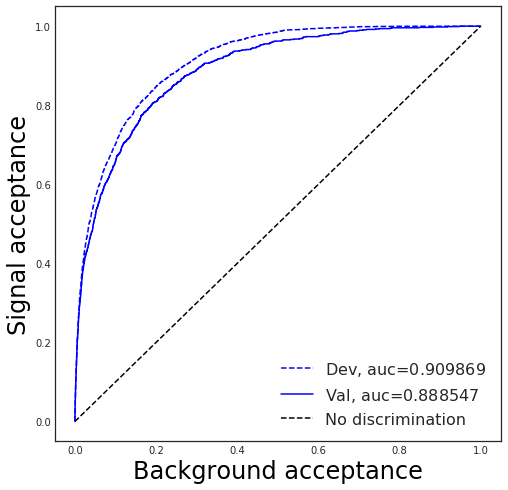

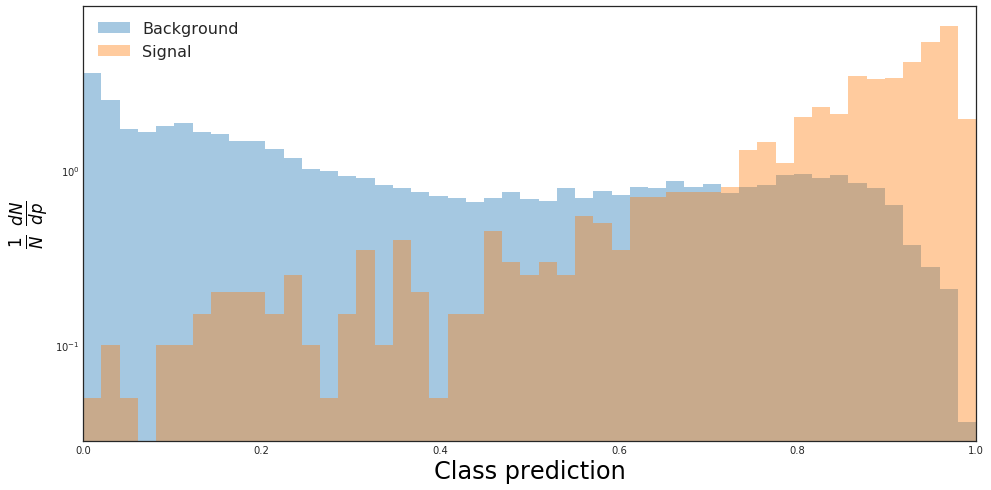

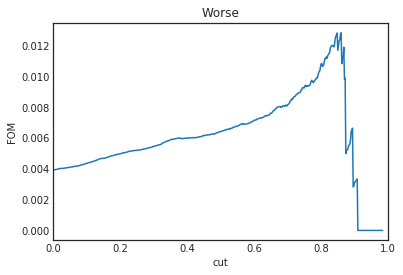

other 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


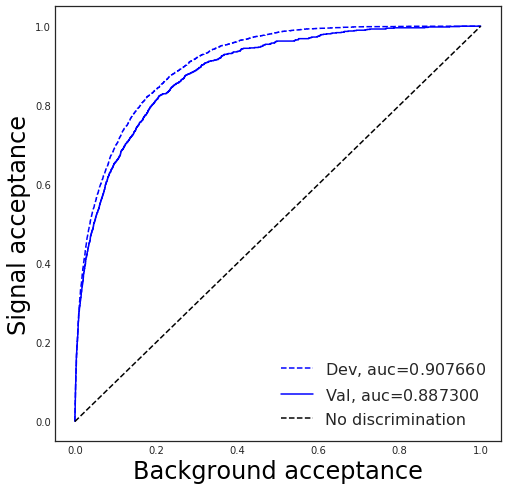

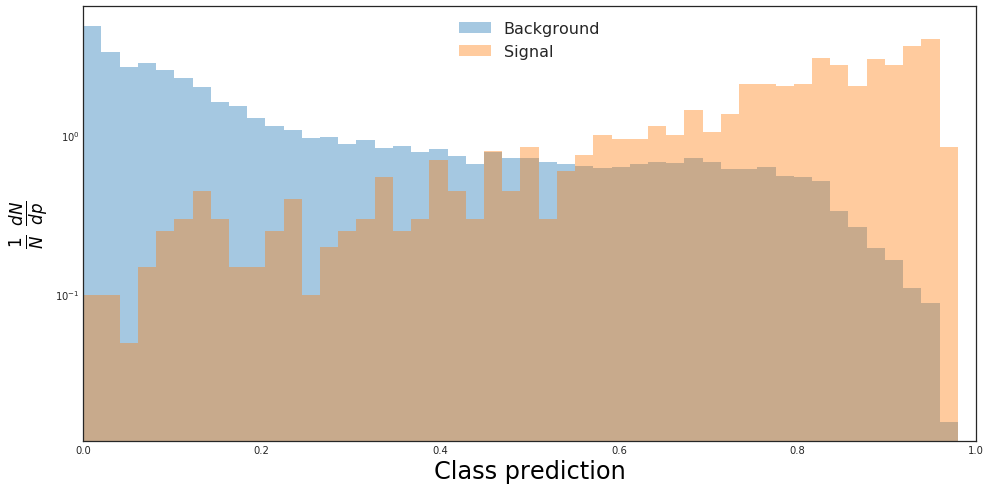

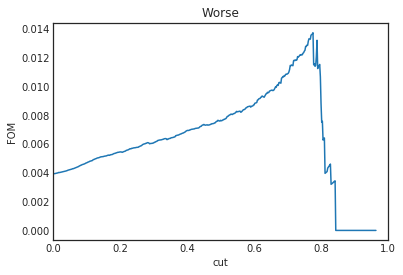

all 1 class :


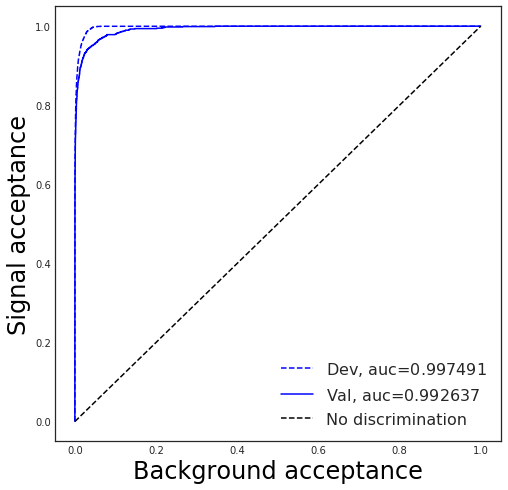

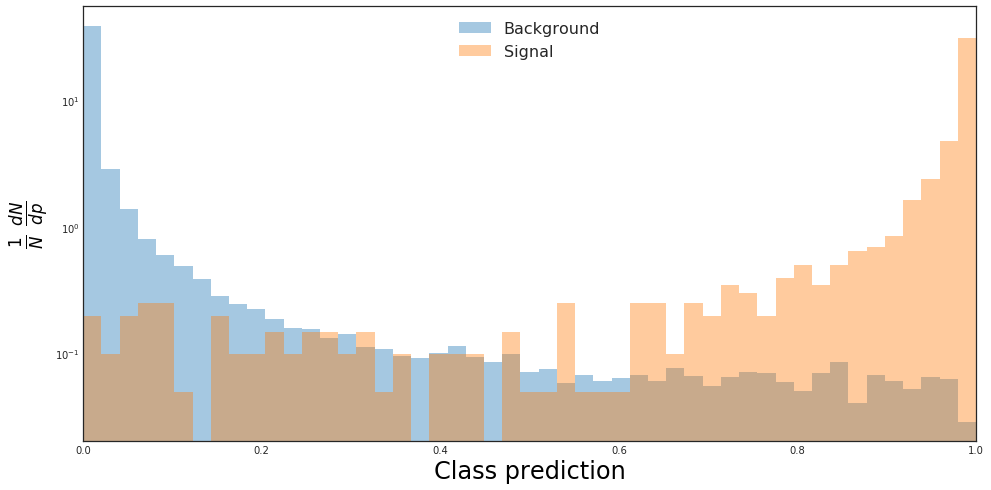

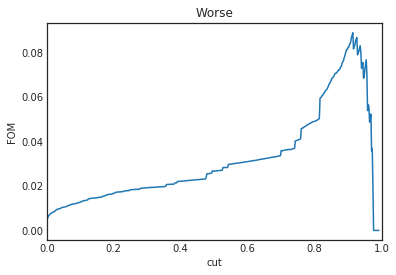

all 1 balanced :


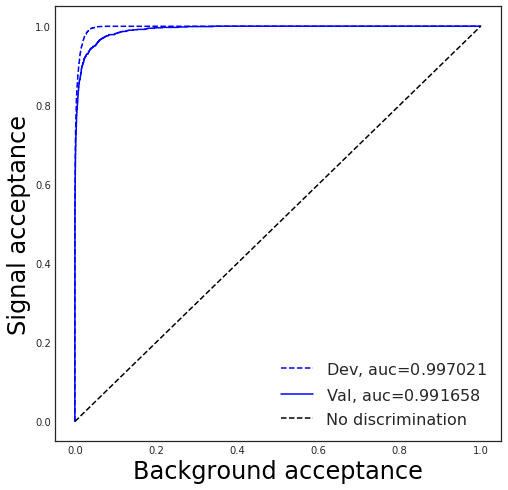

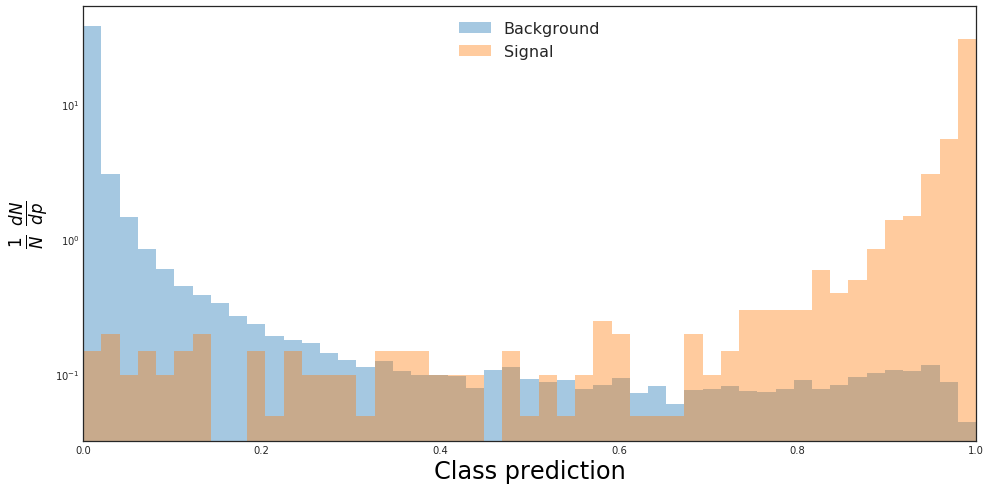

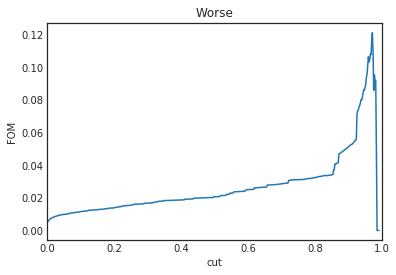

all 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


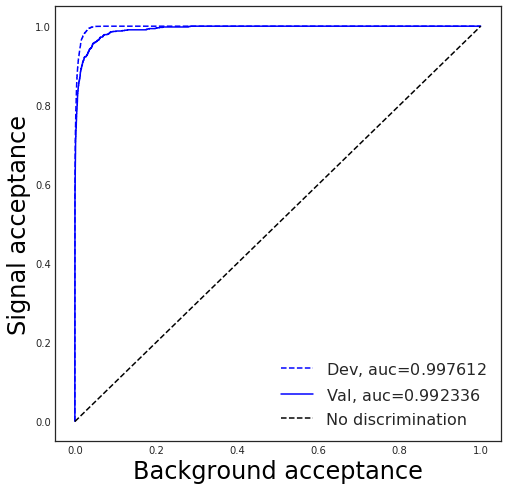

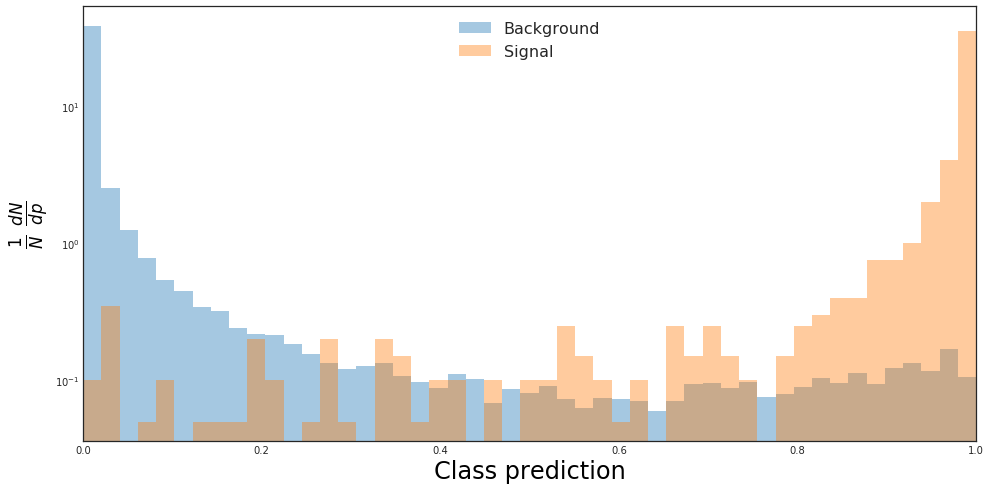

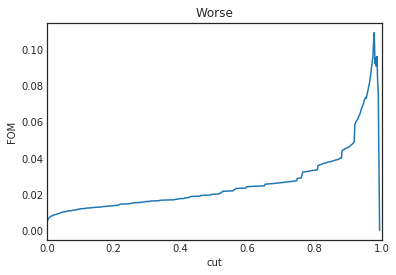

all 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


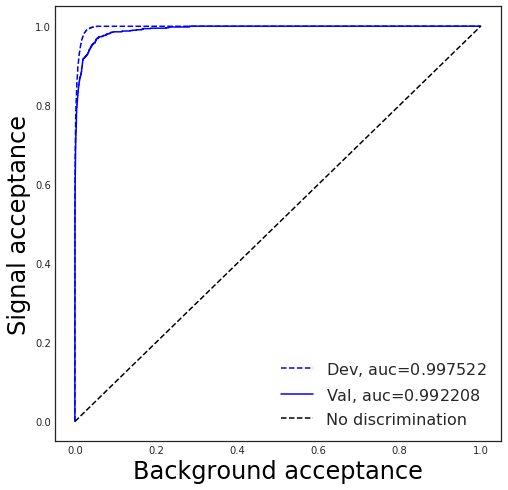

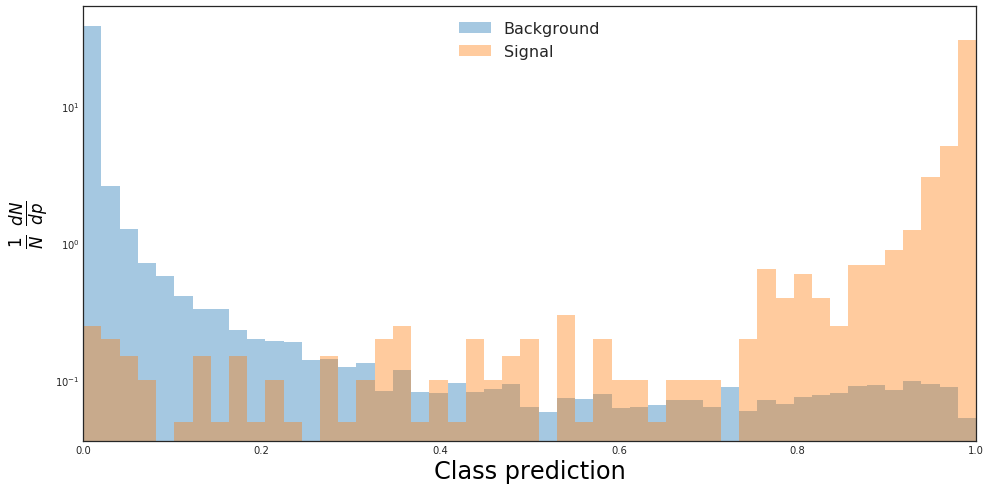

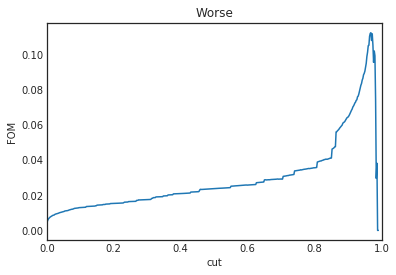

try2 1 class :


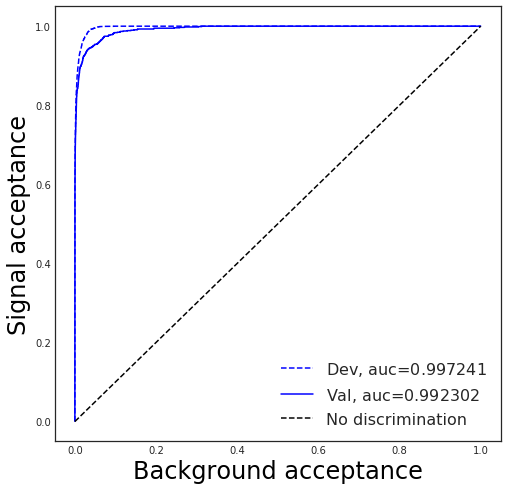

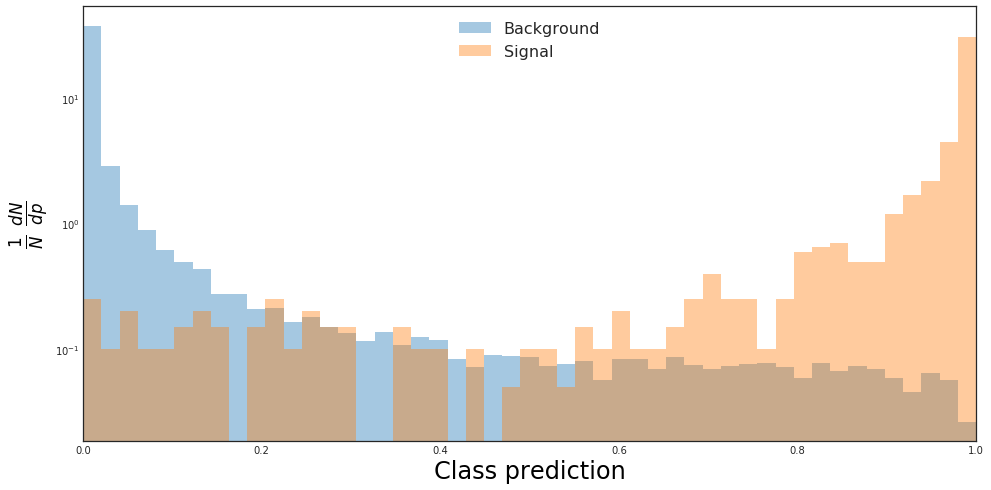

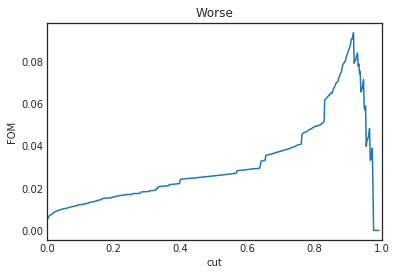

try2 1 balanced :


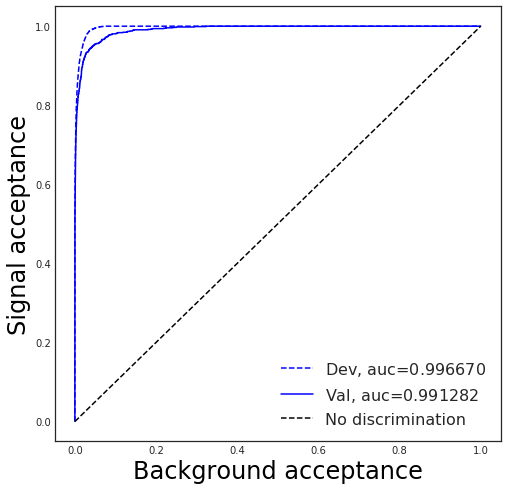

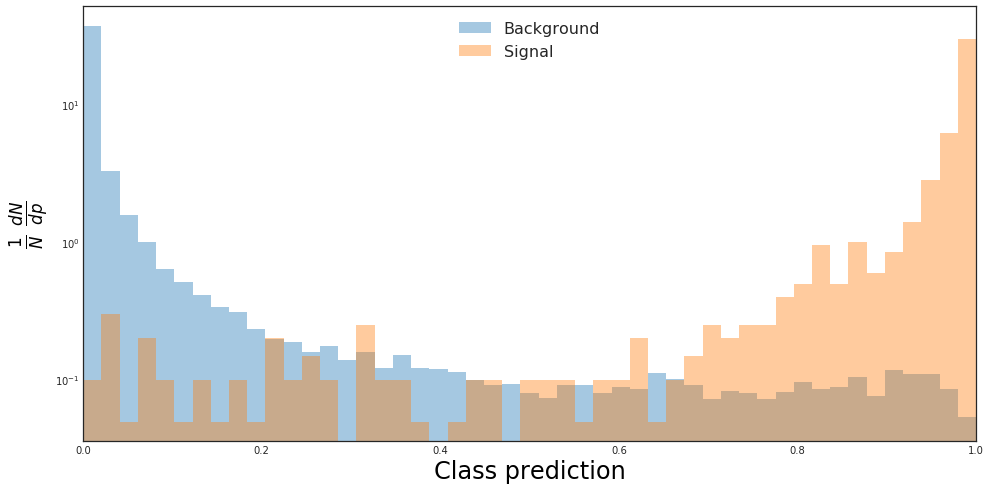

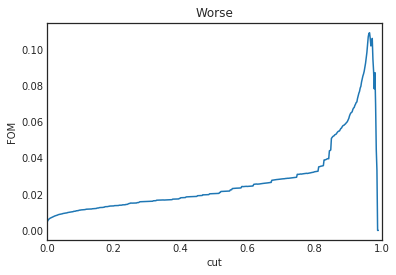

try2 2 class :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


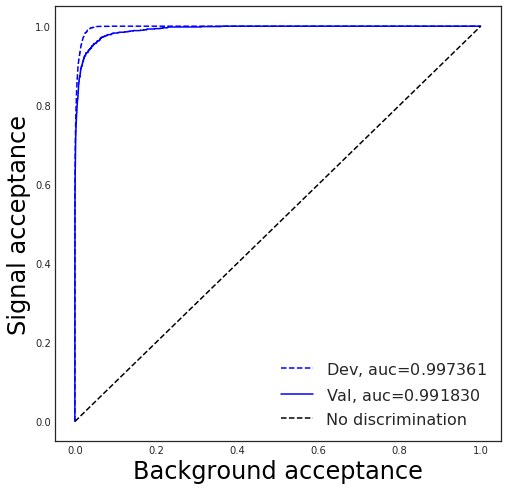

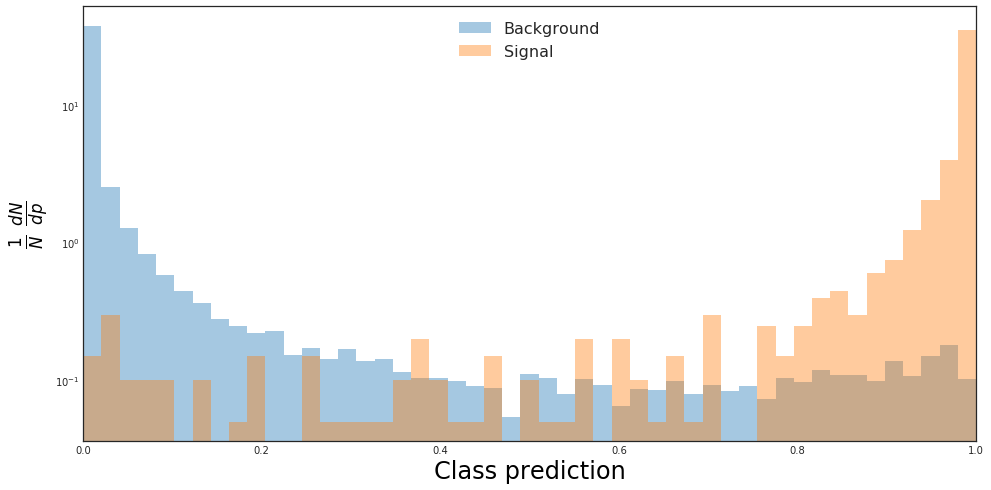

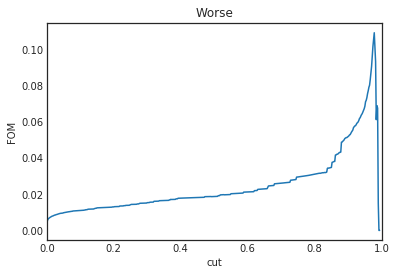

try2 2 balanced :


/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


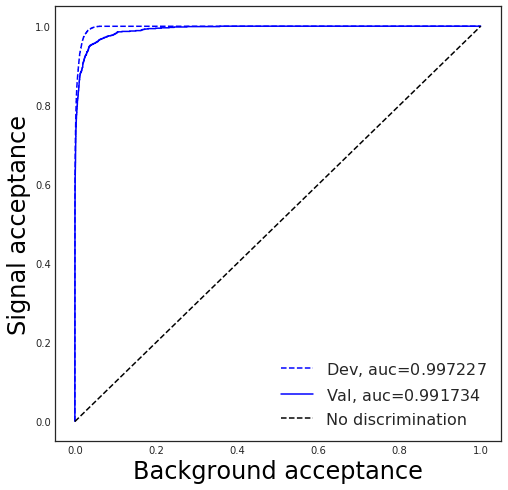

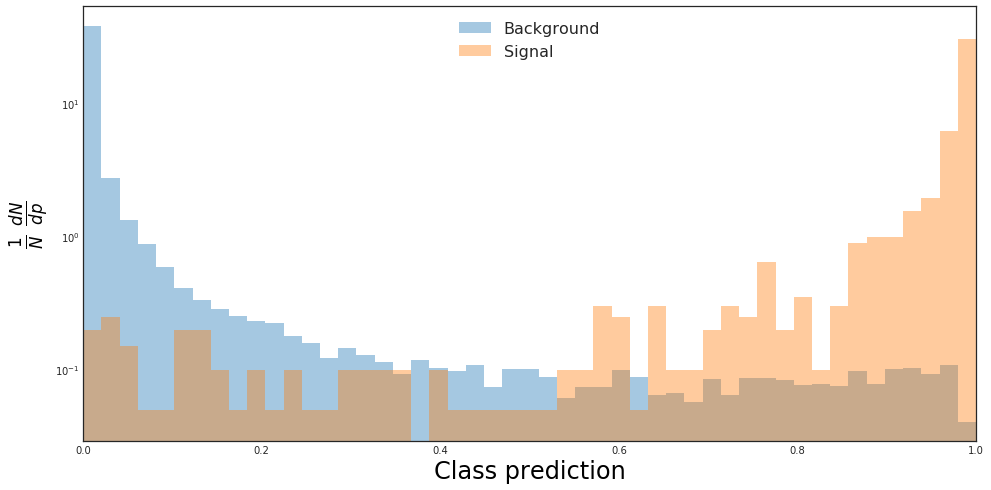

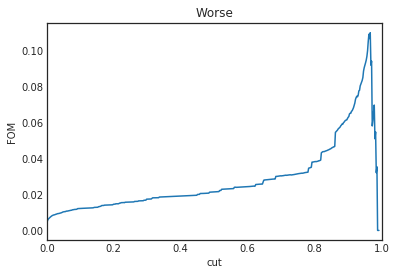

In [14]:
for a in trainingFeatures:
    for c in ['1', '2']:
        for w in ['class', 'balanced']:
            print(a, c, w, ":")
            analyze(a, c , w)

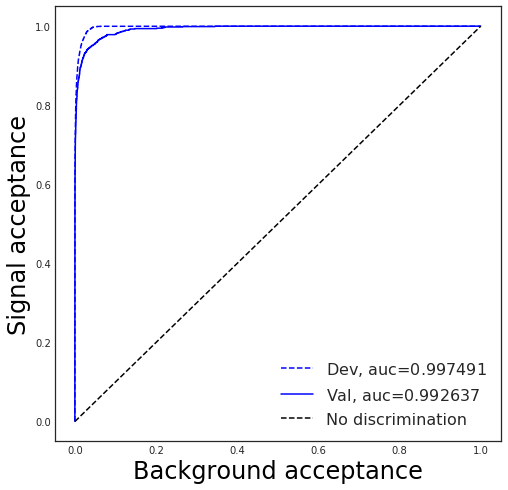

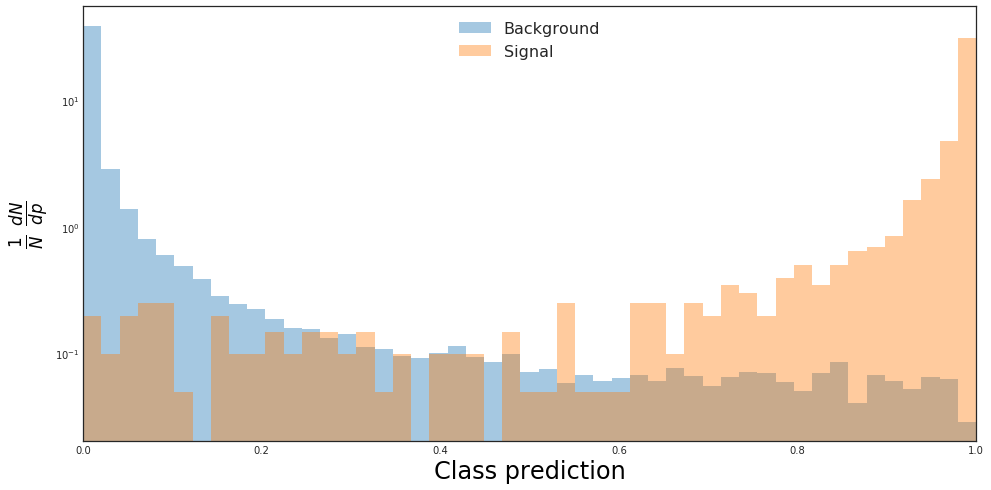

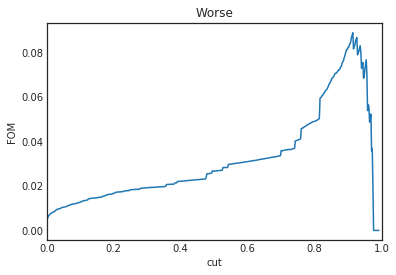

In [51]:
model = analyze('all')

In [52]:
featureInportance = sorted(zip(classTrainFeatures,model.feature_importances_), key= lambda x: x[1], reverse=True)
print(*featureInportance, sep='\n')
print(len(featureInportance))

('diH_kinFit_prob', 0.10526316)
('h_tt_svFit_mass', 0.095010251)
('t_0_pT', 0.053998634)
('regHTT_h_tt_mass', 0.048530418)
('regHH_SO_diH_mass', 0.037593983)
('mT', 0.036226932)
('b_1_csv', 0.035543405)
('regHH_diH_mass', 0.030075189)
('h_bb_mass', 0.025290499)
('regHBB_h_bb_mass', 0.024606971)
('h_tt_pT', 0.021872863)
('h_bb_pT', 0.021189338)
('diH_kinFit_mass', 0.019138755)
('regHTT_diH_mass', 0.019138755)
('b_0_csv', 0.017088175)
('regHTT_h_tt_px', 0.017088175)
('h_tt_mass', 0.015037594)
('regTau_diH_mass', 0.014354067)
('regTau_h_tt_mass', 0.01367054)
('t_0_mass', 0.011619959)
('hT', 0.011619959)
('b_1_pT', 0.010252905)
('mPT_pT', 0.010252905)
('diH_mass', 0.0095693776)
('t_1_pT', 0.0082023237)
('regHTT_t_0_|p|', 0.0075187972)
('regB_b_1_px', 0.0068352702)
('regHTT_h_tt_py', 0.0068352702)
('sT', 0.0061517428)
('t_1_|p|', 0.0061517428)
('t_1_eta', 0.0054682158)
('centrality', 0.0054682158)
('diH_py', 0.0054682158)
('hl_dpy_h_tt_mPT', 0.0054682158)
('regB_h_bb_mass', 0.0054682158)
('